
# Polynomial modeling & regularization
Course: Introduction to Machine Learning

Created by: Xiang Zhang
$\newcommand{\xv}{\mathbf{x}}
 \newcommand{\wv}{\mathbf{w}}
 \newcommand{\yv}{\mathbf{y}}
 \newcommand{\zv}{\mathbf{z}}
 \newcommand{\uv}{\mathbf{u}}
 \newcommand{\vv}{\mathbf{v}}
 \newcommand{\tv}{\mathbf{t}}
 \newcommand{\Chi}{\mathcal{X}}
 \newcommand{\R}{\rm I\!R}
 \newcommand{\sign}{\text{sign}}
 \newcommand{\Tm}{\mathbf{T}}
 \newcommand{\Xm}{\mathbf{X}}
 \newcommand{\Zm}{\mathbf{Z}}
 \newcommand{\Im}{\mathbf{I}}
 \newcommand{\Um}{\mathbf{U}}
 \newcommand{\Vm}{\mathbf{V}}
 \newcommand{\muv}{\boldsymbol\mu}
 \newcommand{\Sigmav}{\boldsymbol\Sigma}
 \newcommand{\Lambdav}{\boldsymbol\Lambda}
$


<br/>
<font color="blue"><b>

NAME: *Hritika Kucheriya*

</b> </font>

## Goal

The goal of this activity is to practice continue practicing remaining steps of our ML setup (training and exploring models, evaluation, and prediction). However, now we are going to explore ridge regression and  polynomial regression using  the algorithms we learned in the linear regression module: ordinary least squares (OLS) and least means squares (LMS)! We'll do so by, once again, by working with the Forest Fire dataset as we have already performed data exploration and preparation so that we can get to the ML algorithms quicker (we'll hopefully). This will be the last week we work with the Forest Fire dataset for awhile!

Your job is to read through the lab and fill in any code segments that are marked by `TODO` headers and comments. **It should be noted, that all the correct outputs are given below each code cell. It might be useful to duplicate all the `TODO` cells so you can try to match the correct output with your own code!** Additionally, use the `todo_check()` output to help guide you.



## Agenda
- Load data
- Removing outliers
- Create the data preparation pipeline using a new order.
- Implement and train linear Ordinary Least Squares with regularization
- Train polynomial ordinary least squares with regularization
- Implement Least mean squares with regularization and mini-batch gradient descent
- Train polynomial least mean squares with regularization
- Select and test the best model

## Table of notation


| Symbol                     | Meaning                     | Symbol    | Meaning                                                          |
|----------------------------|-----------------------------|-----------|------------------------------------------------------------------|
| $\xv$ or $\vec{x}$         | feature/input vector        | $x_i$     | $i$th element of $\xv$                                           |
| $\Xm$                      | input matrix                | $x_{i,j}$ | $i$th row and $j$th column of $\Xm$                              |
| $\yv$ or $\tv$             | labels/targets              | $n$       | number of features or columns
| $\wv$ or $\mathbf{\theta}$ | weight/parameter vector     | $m$       | number of data samples <br>(also used to refer to the slope) |samples or rows                                   |
| $f$ or $h$                 | hypothesis function <br> (i.e., a model)        | $\hat{\yv}$ <br> $f(\xv {;} \wv)$<br>$h(\xv {;} \wv)$ | predictions <br> y-hat |
| $E$              | error or sum of error (loss)  | $SSE$      | sum of squared error function                                            |
| $MSE$                      | mean squared error| $\nabla$  | gradient (nabla)                                       |
| $\partial$                 | partial derivative          | $\alpha$  | learning rate (alpha)                                  |       
| $J$ | general placeholder for <br>the objective function | $x^T$| transpose of a vector or matrix |
$b$ | bias or y-intercept term | $\cdot$ | dot product|
$*$| element-wise<br> multiplication | $\lambda$| regularization<br> variable |

## Imports

In [258]:
# Imports for this notebook
import gc
import os
import warnings
import traceback
from typing import List, Tuple, Callable

# Debugger
from IPython.core.debugger import set_trace

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [259]:
# Set this to True if you DO NOT want to run the
# garbage_collect() functions throughout the notebook
turn_off_garbage_collect = False

def garbage_collect(vars_):
    if not turn_off_garbage_collect:
        for v in vars_:
            if v in globals():
                del globals()[v]
        collected = gc.collect()

def todo_check(condi_err):
    failed_err = "You passed {}/{} and FAILED the following code checks:{}"
    failed = ""
    n_failed = 0
    for check, (condi, err) in enumerate(condi_err):
        if not condi:
            n_failed += 1
            failed += f"\nFailed check [{check+1}]:\n\t Tip: {err}"

    if len(failed) != 0:
        passed = len(condi_err) - n_failed
        err = failed_err.format(passed, len(condi_err), failed)
        raise AssertionError(err.format(failed))
    print("Your code PASSED the code check!")

# Problem statement summary and data loading

![](https://fee.org/media/38322/forest-fire-3782544_1280.jpg?anchor=center&mode=crop&height=656&widthratio=2.1341463414634146341463414634&rnd=132451547710000000)

### Problem statement summary

Recall that our goal here is to help prevent and make firefighting easier by identifying "high risk" areas by predicting how much area of a forest could burn when a fire occurs. We are attempting to achieve this by using supervised learning where our labels corresponds to the amount of forest area (in hectares) that has burned in the past.

### Data loading

To begin, let's fetch the Forest Fire dataset. If you don't have it then download it using the following link: https://archive.ics.uci.edu/ml/datasets/Forest+Fires. When you arrive at the UCI webite click the "Data Folder" button near the top right to download the dataset. Once clicked, download the following file: `forestfires.csv`.

Be sure to move the `forestfires.csv` file to the **SAME** directory/folder that this Jupyter Notebook is in (i.e., the current path of the notebook). We need to do this so that when we go to load the data we can easily path to the files! Run the below code to check which will print your notebook's current path and which directory the notebook is in!

In [260]:
print(f"The current path for your notebook is:\n {os.getcwd()}\n")
print(f"Your notebook is currently in the following directory:\n {os.path.basename(os.getcwd())}")

The current path for your notebook is:
 /content

Your notebook is currently in the following directory:
 content


#### TODO 1
Complete the TODO by loading the `forestfires.csv`.

1. Load Forest Fires dataset using the Pandas. Store the output into the `forestfire_df` variable.
    1. Hint: We wrote a warning below to alert you if you didn't move your notebook to the correct location. So if you are getting an error take a second to read what it says.

In [261]:
# This line checks to make sure the forestfire.csv is in the
# same directory as this notebook.
if not os.path.exists("forestfires.csv"):
    warnings.warn(f"The forestfires.csv is not detected in your local path! " \
                    f"You need to move the 'forestfires.csv' file to the same " \
                    f"location/directory as this notebook which is {os.getcwd()}")
# TODO 1.1
forestfire_df = pd.read_csv("forestfires.csv")
forestfire_df

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


# Visualization and exploration

Now we have already done most of the visualization and data exploration in prior labs. However, let's start by reviewing some of the ideas we learned while exploring the data and investigate some new ideas such as finding and removing outliers.

## Observing linear and non-linear trends

First, let's review how each one of our features correlates with our target 'area'. Recall, we have take the log of our target 'area' in order to spread out the skewed distribution towards being more normal. Below, is the code from previous labs for plotting our target 'area' against every input feature.

Once again, take note that none of our features, when compared 1-to-1 with our target, seem to show a linear or non-linear trend.

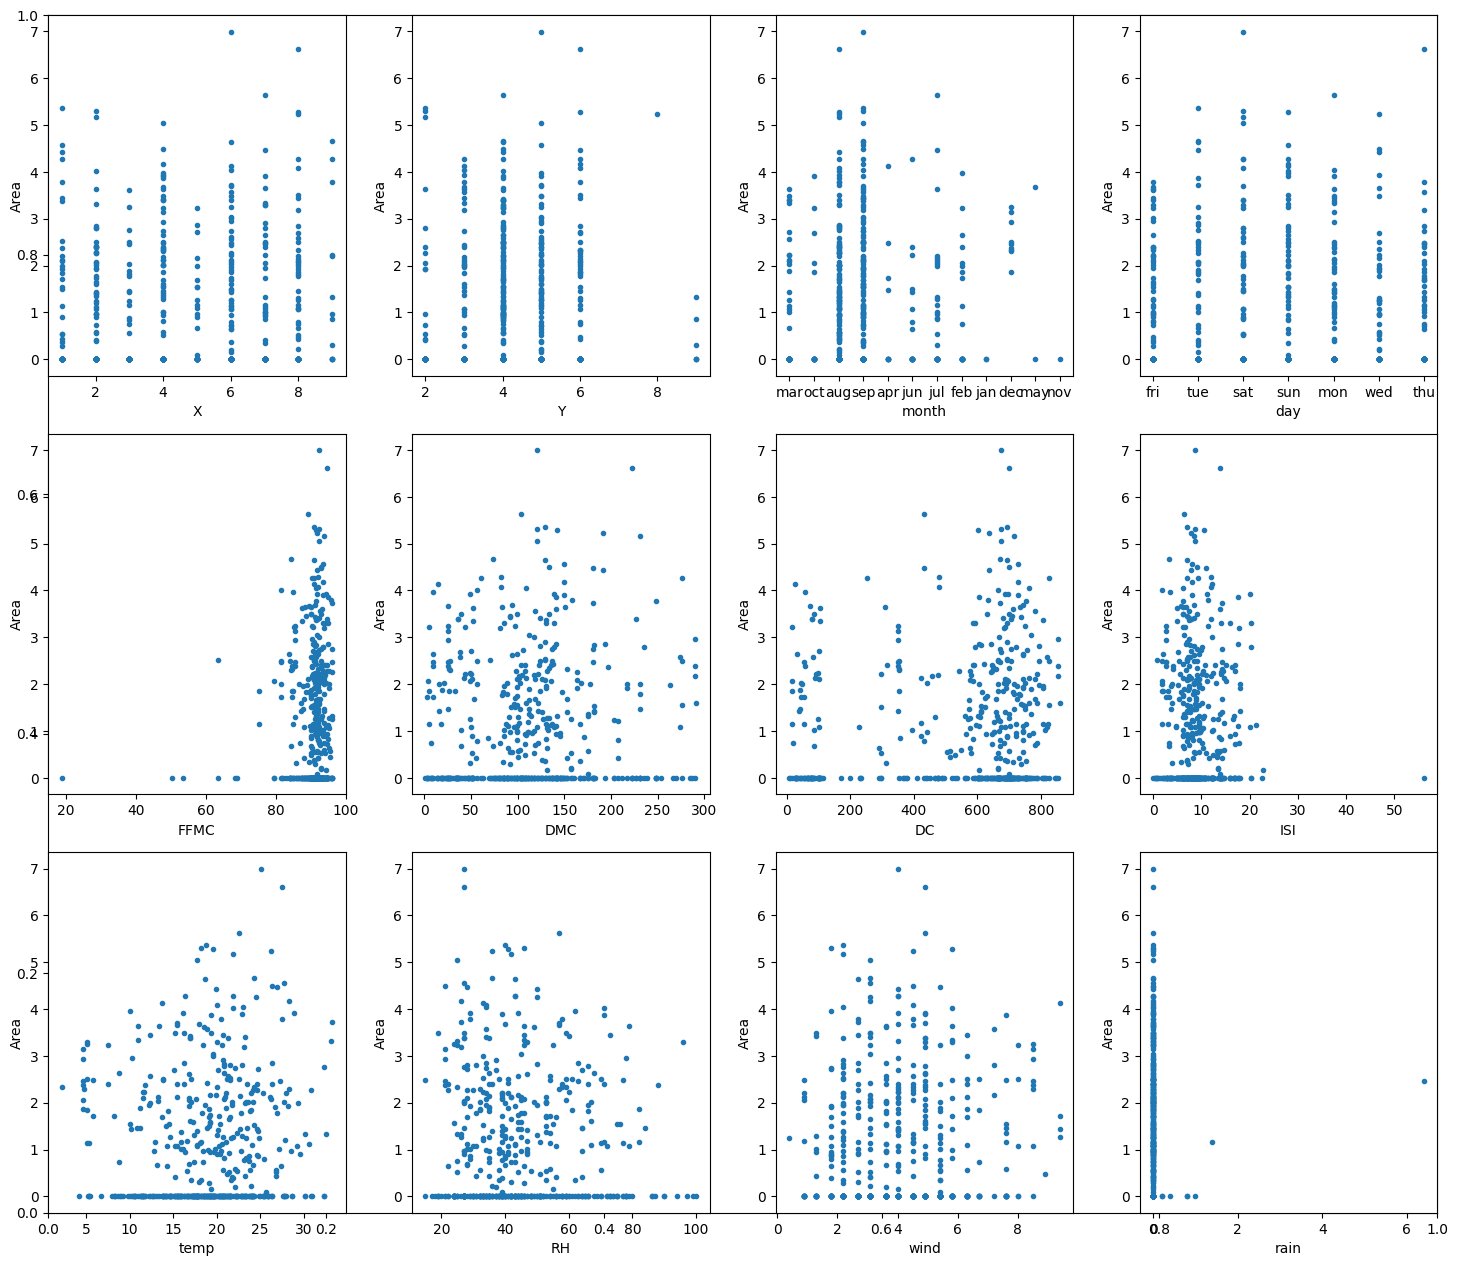

In [262]:
log_area_values = np.log1p(forestfire_df['area'])
features = forestfire_df.drop('area', axis=1)

fig, _ = plt.subplots(figsize=(15, 13))

# column_name holds the current column name
# idx holds the current column index
# You can use either to index features to get the current feature
for idx, column_name in enumerate(features.columns.values):
    plt.subplot(3, 4, idx+1)
    plt.plot(features[column_name], log_area_values, '.')
    plt.ylabel('Area')
    plt.xlabel(column_name)
fig.tight_layout()
plt.show()

## Finding and removing outliers

Next, you might recall our linear algorithms in the linear regression lab making were weird predictions, particularly in our validation data. When our algorithm makes an extreme prediction this is because our model has overfit to the training data. One reason for overfitting could be that our training dataset isn't diverse enough. This means there aren't enough data samples covering common or niche (i.e, outlier) cases in our data!

Leaving in extreme outliers in our data can actually cause our model harm. One naive way to overcome this issue is to find and remove outliers.

But what exactly is an outlier? Well, **an outlier is just a rare or uncommon data sample**. What is classified as "rare" is rather ambiguous. One concrete way to find "rare" data samples is by looking at how many standard deviations (SD) a data sample is away from a feature's mean!  

## Box plots

Let's start off by making some boxplots using Seaborn. Recall that a box plot is defined as follows:

>  Box plots (also called box-and-whisker plots or box-whisker plots) give good graphical image of the concentration of the data. They also show how far the extreme values are from most of the data. A box plot is constructed from five values: the minimum value, the first quartile, the median, the third quartile, and the maximum value.
> - Reference: https://courses.lumenlearning.com/introstats1/chapter/box-plots/

Below is an image of a box plot.
    
<img src="https://media.geeksforgeeks.org/wp-content/uploads/20201127012952/boxplot-660x233.png" width=500 height=500>

The labels of a box plot are defined as follows:

- **Minimum**: It is the minimum value in the dataset excluding the outliers

- **First Quartile (Q1)**: 25% of the data lies below the First (lower) Quartile.

- **Median (Q2**: It is the mid-point of the dataset. Half of the values lie below it and half above.

- **Third Quartile (Q3)**: 75% of the data lies below the Third (Upper) Quartile.

- **Maximum**: The maximum value in the dataset excluding the outliers.

Below we import Seaborn. Seaborn is a high-level plotting library that wraps Matplotlib and can make plotting very easy! We'll be using it to create our box plots.

In [263]:
import seaborn as sns

#### TODO 2
Complete this TODO by finishing the subplot of box plots using Seaborn and Matplotlib. Use the below image to check your output as no `todo_check()` is given.

1. Define a subplot using matplotlibs `subplots()` function. Store the output into two variables: `fig` and `axs`. Here, the `axs` variable will hold all our subplot grids which will determine which subplot we plot to. See [docs](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) for more help regarding subplots. Pass the following arguments that correspond to the below descriptions:
    1. The subplot should have 11 row and 1 column, meaning there will be 11 total subplots. See the arguments in the docs that refer to setting the number of rows and columns!
    1. Additionally, you will need to pass the keyword argument (kwarg) `figsize` (this is not listed directly in the docs). This should be equal to (20, 30) as this will ensure our plot will make all the subplots big enough to be readable. Here 20 (index 0) is the width and 30 (index 1) is the height. Feel free to increase the width/height if it is too small for you.
    
2. Use Seaborn's `boxplot()` function to create a box plot for each of our numerical features. Call the `boxplot()` function using Seaborn and pass the following arguments:
    1. Pass the keyword argument `x` which takes the current numerical feature's data. Do so by indexing `forestfire_df` using the current feature numerical feature's column name stored in `column_name`.  
    2. Pass the keyword argument (kwarg) `ax` which determines which subplot to plot to. Do so by passing the `axs` indexed by `idx`. `idx` represents the current subplot index we are currently on! See [docs](https://seaborn.pydata.org/generated/seaborn.boxplot.html) for box plot.
    
    
<img src="https://live.staticflickr.com/65535/51889339624_8bd506345b_o.png" width="480" height="821" alt="lab-4_2">

In [264]:
# Gets all the numerical feature data
numerical_features = forestfire_df.drop(['day', 'month'], axis=1)
numerical_features

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


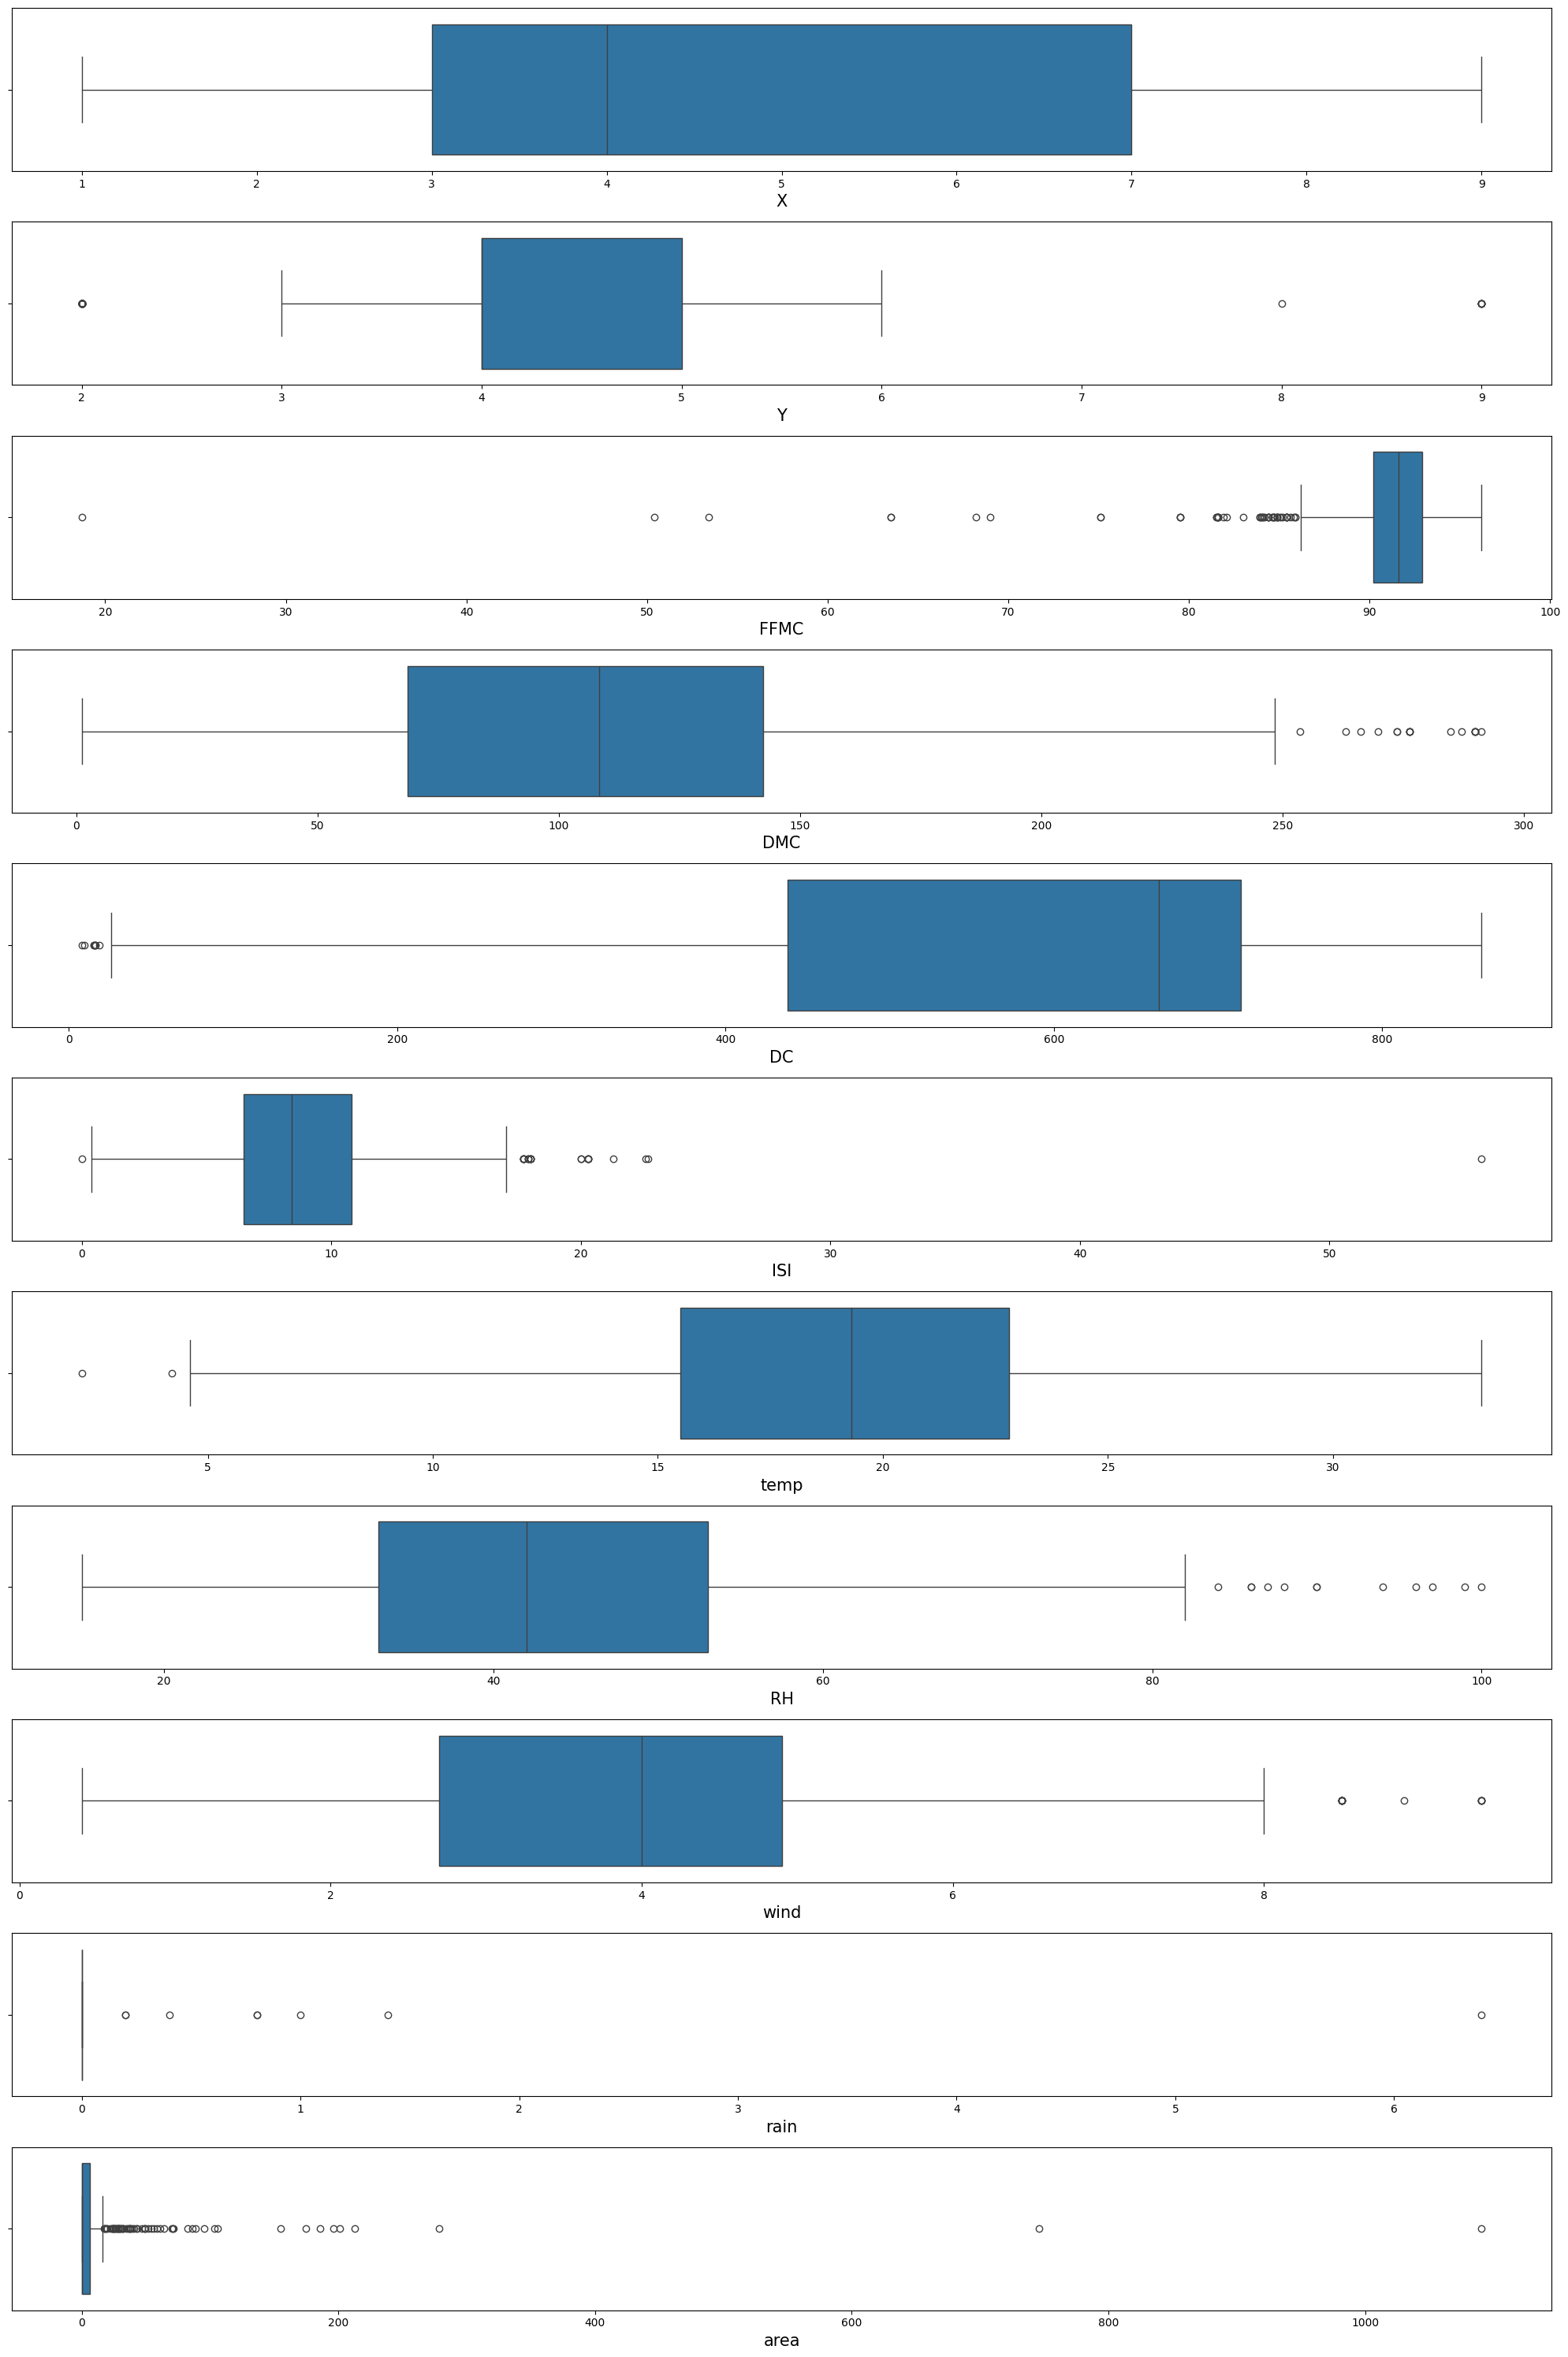

In [265]:
# TODO 2.1
fig, axs = plt.subplots(nrows=11, ncols=1, figsize=(20, 30))

# We flatten the axs variable as it would be a 2D array making it
# harder to index
axs = axs.flatten()

# Index refers to the current index of the numerical feature columns
for idx, column_name in enumerate(numerical_features.columns):
    # TODO 2.2
    sns.boxplot(x=numerical_features[column_name], ax=axs[idx])
    # Sets the x-axis title for each subplot
    axs[idx].set_xlabel(axs[idx].get_xlabel(), fontsize=15)

# Formats subplots so they overlap less
fig.tight_layout()
# Shows entire plot once done
plt.show()

Review the box plots you just plotted. The x-axis just represents a particular feature. Notice that **the black circles/diamonds are data points that exceed the min and max of our data. These are outliers that Seaborn automatically computes for us.** Essentially, it detects outliers using the inter-quartile range of the data and sets a new min and max not including the excluded outliers. **In short, Seaborn defines outliers as the ones smaller than Q1 - 1.5\*IQR or larger than Q3+1.5\*IQR. IQR means Inter Quartile Range which is the range between Q1 and Q3.**
See this [post](https://medium.com/@agarwal.vishal819/outlier-detection-with-boxplots-1b6757fafa21) on how Seaborn computes outliers if you are interested.

As we can see all our features have some data samples that are outliers. Notice that the extreme cases like 'rain' and 'area' essentially squash our box plot such that we can barely even see it!

Let's further explore how we can detect this outliers in a non-visual manner. Recall that one way to detect an outlier is by looking at how many standard deviations (SD) a given feature for a data sample is away from the feature mean across all data samples.

To do this we can compute the z-score for all our features. Recall that a [z-score](https://www.investopedia.com/terms/z/zscore.asp) reports how many SDs a feature is above or below the feature mean for a given data sample. Further recall, z-scores assume each the feature's data is normally distributed. You might recall the image of a normal or Gaussian distribution such as the below image from stats class. For now, we'll make this assumption even though it might not be true.

<img src="https://i.stack.imgur.com/JERva.jpg" width=500 height=500>


#### TODO 3
Complete the TODO by computing the z-scores for all our features and data samples by using Scipy's `stats.zscore()` function.

1. Import the `zscore` from `scipy.stats`.
2. In order to compute the z-scores for every data sample and each feature we need to use the use the `.apply()` method ([docs](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html)) that is available to our `numerical_features` DataFrame. This will apply the `zscore` function to each feature in `numerical_features` and compute the z-scores for each feature (across samples). Store the output into `z`.
    1. Hint: You only need to pass the function reference of `zscore`. Meaning, you don't need `()`.

In [266]:
# TODO 3.1
from scipy.stats import zscore

# TODO 3.2
z = numerical_features.apply(zscore)
display(z)

todo_check([
    (np.all(np.isclose(z.values[0, :3].flatten(), [1.00831277,  0.56986043, -0.80595947], rtol=.01)),  'z has potentially contains incorrect values')
])

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,1.008313,0.569860,-0.805959,-1.323326,-1.830477,-0.860946,-1.842640,0.411724,1.498614,-0.073268,-0.202020
1,1.008313,-0.244001,-0.008102,-1.179541,0.488891,-0.509688,-0.153278,-0.692456,-1.741756,-0.073268,-0.202020
2,1.008313,-0.244001,-0.008102,-1.049822,0.560715,-0.509688,-0.739383,-0.692456,-1.518282,-0.073268,-0.202020
3,1.440925,1.383722,0.191362,-1.212361,-1.898266,-0.004756,-1.825402,3.233519,-0.009834,0.603155,-0.202020
4,1.440925,1.383722,-0.243833,-0.931043,-1.798600,0.126966,-1.291012,3.356206,-1.238940,-0.073268,-0.202020
...,...,...,...,...,...,...,...,...,...,...,...
512,-0.289524,-1.057862,-1.640083,-0.846648,0.474768,-1.563460,1.536084,-0.753800,-0.736124,-0.073268,-0.100753
513,-1.154748,-0.244001,-1.640083,-0.846648,0.474768,-1.563460,0.519019,1.638592,0.995798,-0.073268,0.651674
514,1.008313,-0.244001,-1.640083,-0.846648,0.474768,-1.563460,0.398350,1.577248,1.498614,-0.073268,-0.026532
515,-1.587360,-0.244001,0.680957,0.549003,0.269382,0.500176,1.156839,-0.140366,-0.009834,-0.073268,-0.202020


Your code PASSED the code check!


The above output shows us the z-score for all data samples with respect to every numerical feature. For example, data sample 0 for feature `DMC` reports a z-score of about $-1.32$. This means, data sample 0 has a value for `DMC` that is roughly $1.32$ standard deviations below the `DMC` mean value (mean taken across all data samples for the `DMC` feature).

Now comes the ambiguity of the term "outlier." We need to select a threshold which will determine if an data sample is an outlier. To do so, we have to pick the number of standard deviations a data sample must be above or below the mean to be considered an outlier.

For instance, we could say that all data samples that have a z-score or SD above 3 is consider an outlier. This would mean that approximately  99% of our data should fall within -3 or +3 standard deviations, IF all our features are normally distributed.

#### TODO 4
Complete the TODO by finishing the `outlier_locations()` function which finds all the locations of data samples that have at least one feature above or below the passed SD threshold `threshold`.

1. Use the NumPy's `where()` function to find the locations of all the data samples greater than the given threshold `threshold`. Store the output into `outlier_locs`. To do so, do the following:
    1. First, we need to take the absolute value of `z` using the `np.abs()` function so that we have no negative values. Store this output into the variable `abs_z`.
        1. Note: negative values just indicate a sample is below the mean, which doesn't matter to us. We just want to find all samples that are a given distance from the mean regardless if they are above or below.
    2. Next we need to call NumPy's `where()` function and pass the condition `abs_z > threshold`. This will tell the `where()` function to find all samples that are above the given SD threshold!
    3. Lastly, return the `outlier_locs` variable

In [267]:
def outlier_locations(z, threshold):
    # TODO 4.1.A
    abs_z = np.abs(z)
    # TODO 4.1.B
    outlier_locs = np.where(abs_z > threshold)
    # TODO 4.1.C
    return outlier_locs

To test your `outlier_locations()` implementation run the below code. It will print out all the data samples which are considered outliers given a 3 SD threshold.

In [268]:
outlier_rows, outlier_cols = outlier_locations(z, threshold=3)

display(forestfire_df.iloc[outlier_rows])

todo_check([
    (isinstance(outlier_rows, np.ndarray), 'outlier_locs is not of type np.ndarray'),
])
todo_check([
    (outlier_rows.shape == (32,) or outlier_rows.shape == (32,1), 'outlier_rows has the wrong shape'),
])

garbage_collect(['outlier_rows', 'outlier_cols'])

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
12,6,5,aug,fri,63.5,70.8,665.3,0.8,17.0,72,6.7,0.0,0.00
22,7,4,jun,sun,94.3,96.3,200.0,56.1,21.0,44,4.5,0.0,0.00
75,9,9,feb,thu,84.2,6.8,26.6,7.7,6.7,79,3.1,0.0,0.00
76,9,9,feb,fri,86.6,13.2,43.0,5.3,15.7,43,3.1,0.0,0.00
97,3,4,mar,sat,69.0,2.4,15.5,0.7,17.4,24,5.4,0.0,0.00
130,4,6,feb,sat,68.2,21.5,87.2,0.8,15.4,40,2.7,0.0,0.00
138,9,9,jul,tue,85.8,48.3,313.4,3.9,18.0,42,2.7,0.0,0.36
151,9,9,jul,sun,90.1,68.6,355.2,7.2,24.8,29,2.2,0.0,1.36


Your code PASSED the code check!
Your code PASSED the code check!


Filtering out any data sample that falls outside 3 SDs seems a little to liberal at the moment. Further, since we will be using 'area' as our target let's not include it in the outlier detection for now. Thus, let's exclude 'area' from the outlier detection and increase our threshold to 5 to be more conservative for now.

In [269]:
exclude_area = numerical_features.drop('area', axis=1)
ea_z = exclude_area.apply(zscore)
outlier_rows, outlier_cols = outlier_locations(ea_z, threshold=5)

Below we print out all the data samples that contain a feature that has an extreme z-score (above 5 SDs) along with the data sample index and name of the feature with the offending z-score is in.

In [270]:
for row, col in zip(outlier_rows, outlier_cols):
    feature_name = z.columns[col]
    z_score = z.iloc[row, col]
    print(f"Data sampe: {row} Feature: {feature_name} z-score: {z_score}")
    display()

Data sampe: 22 Feature: ISI z-score: 10.33538083615606
Data sampe: 299 Feature: FFMC z-score: -6.753624014162549
Data sampe: 312 Feature: FFMC z-score: -7.297617722244193
Data sampe: 379 Feature: FFMC z-score: -13.045817904306904
Data sampe: 499 Feature: rain z-score: 21.572283715947112


Taking a closer look, using the above output, we can see that the data sample at index 499 is 21 SDs away from the rain mean! This is an example of an extreme outlier.

Take some time to just observe each outlier's feature values below. Notice that data sample 499 has a rain value of 6.4 which is considered 21 SDs above the mean!

In [271]:
forestfire_df.iloc[outlier_rows]

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
22,7,4,jun,sun,94.3,96.3,200.0,56.1,21.0,44,4.5,0.0,0.00
299,6,5,jun,sat,53.4,71.0,233.8,0.4,10.6,90,2.7,0.0,0.00
312,2,4,sep,sun,50.4,46.2,706.6,0.4,12.2,78,6.3,0.0,0.00
379,4,5,jan,sun,18.7,1.1,171.4,0.0,5.2,100,0.9,0.0,0.00
499,7,5,aug,tue,96.1,181.1,671.2,14.3,27.3,63,4.9,6.4,10.82


### Dropping outliers
Below we define a function for you for dropping outliers. Notice it uses our `outlier_locations()` function.

In [272]:
def drop_outliers(df, threshold, verbose=False):
    # Remove area
    exclude_area = numerical_features.drop('area', axis=1)
    # Get z-scores
    z = exclude_area.apply(zscore)
    # Find outlier locations
    outlier_rows, outlier_cols = outlier_locations(z, threshold=threshold)
    # Drop samples
    new_df = df.drop(outlier_rows, axis=0)

    if verbose:
        print("Dropping...")
        print(f"\tforestfire_df BEFORE dropping: {forestfire_df.shape}")
        print(f"\tforestfire_df AFTER dropping: {new_df.shape}")
        display(df.iloc[outlier_rows])

    return new_df

Below the `TEST_drop_outliers()` function provides code for how to call the `drop_outliers()` function.

In [273]:
def TEST_drop_outliers():
    new_df = drop_outliers(forestfire_df, threshold=5, verbose=True)

TEST_drop_outliers()
garbage_collect(['TEST_drop_outliers'])

Dropping...
	forestfire_df BEFORE dropping: (517, 13)
	forestfire_df AFTER dropping: (512, 13)


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
22,7,4,jun,sun,94.3,96.3,200.0,56.1,21.0,44,4.5,0.0,0.00
299,6,5,jun,sat,53.4,71.0,233.8,0.4,10.6,90,2.7,0.0,0.00
312,2,4,sep,sun,50.4,46.2,706.6,0.4,12.2,78,6.3,0.0,0.00
379,4,5,jan,sun,18.7,1.1,171.4,0.0,5.2,100,0.9,0.0,0.00
499,7,5,aug,tue,96.1,181.1,671.2,14.3,27.3,63,4.9,6.4,10.82


# Data Preparation Pipeline

Now it's time to recreate our data preparation pipelines we used in prior weeks. In this lab we will try something slightly different. **This time, we are going to apply all our data cleaning and transformation operations after splitting the data.** While we will get the same results this approach has some new issues we have to overcome that you should be aware of. That being said, either approach is viable.

## Splitting data

Now onto splitting! Below we redefine the splitting functions we have seen in prior labs.

In [274]:
def feature_label_split(df):
    X = df.drop('area', axis=1)
    y = df[['area']].copy()

    return X, y

Below, within the `TEST_feature_label_split()` function is an example of how to call the `feature_label_split()` function.

In [275]:
def TEST_feature_label_split():

    # Drop outliers
    dropped_forestfire_df = drop_outliers(forestfire_df, threshold=5)
    # Apply feature and label splitting
    X, y = feature_label_split(dropped_forestfire_df)

    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")

TEST_feature_label_split()
garbage_collect(['TEST_feature_label_split'])

X shape: (512, 12)
y shape: (512, 1)


In [276]:
from sklearn.model_selection import train_test_split

def train_valid_test_split(X, y, seed=42):
    X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=.2, random_state=seed)
    X_trn, X_vld, y_trn, y_vld = train_test_split(X_trn, y_trn, test_size=.2, random_state=seed)

    return X_trn, y_trn, X_vld, y_vld, X_tst, y_tst

Below, within the `TEST_train_valid_test_split()` function is an example of how to call the `train_valid_test_split()` function.

In [277]:
def TEST_train_valid_test_split():

    # Drop outliers
    dropped_forestfire_df = drop_outliers(forestfire_df, threshold=5)
    # Apply feature and label splitting
    X, y = feature_label_split(dropped_forestfire_df)
    # Apply train, validation and test set splitting
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = train_valid_test_split(X, y)

    print(f"X_trn shape: {X_trn.shape}")
    print(f"y_trn shape: {y_trn.shape}")
    print(f"X_vld shape: {X_vld.shape}")
    print(f"y_vld shape: {y_vld.shape}")
    print(f"X_tst shape: {X_tst.shape}")
    print(f"y_tst shape: {y_tst.shape}")

TEST_train_valid_test_split()
garbage_collect(['TEST_train_valid_test_split'])
# garbage_collect(['dropped_forestfire_df', 'X', 'y', 'X_trn', 'y_trn', 'X_vld', 'y_vld', 'X_tst', 'y_tst'])

X_trn shape: (327, 12)
y_trn shape: (327, 1)
X_vld shape: (82, 12)
y_vld shape: (82, 1)
X_tst shape: (103, 12)
y_tst shape: (103, 1)


## Applying data cleaning and transformations
Next, let's explore what changes when we want to clean and transform our data after splitting. With this approach, we can break our data cleaning and transformations into two different groups: target cleaning and feature cleaning.

Let's start by redefining our `DataFrameColumnTransformer` from last week and importing our sklearn classes.

In [278]:
import sklearn
# Check to make sure you have the right version of sklearn
assert sklearn.__version__  >= '1.0.1', f'sklearn version is only {sklearn.__version__} and needs to be > 1.0.1'

In [279]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

- Changes to ` DataFrameColumnTransformer` class
    - We added the kwarg for `remainder='passthrough'` to the `ColumnTransformer` initialization which will automatically pass any unused columns to the output given by the `ColumnTransformer` class. You no longer have to manually specify this stage!

In [280]:
class DataFrameColumnTransformer(TransformerMixin):
    def __init__(self, stages: List[Tuple]):
        self.col_trans = ColumnTransformer(stages, remainder='passthrough')

    def fit(self, X: pd.DataFrame):
        """ Runs our ColumnTransformer.fit() method """
        self.col_trans.fit(X)
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """ Runs our ColumnTransformer.transform() method """
        output_arr = self.col_trans.transform(X)

        return self.to_dataframe(output_arr)

    def to_dataframe(self, arr: np.ndarray) -> pd.DataFrame:
        """Converts our output of ColumnTransformer into a DataFrame"""
        feature_names = self.col_trans.get_feature_names_out()

        # Remove the "__" that ColumnTransformer adds to our feature names
        # when we call self.col_trans.get_feature_names_out()
        for i, name in enumerate(feature_names):
            if '' in name:
                feature_names[i] = name.split('__', 1)[-1]

        # Creates a Pandas Dataframe
        df = pd.DataFrame(arr, columns=feature_names)
        return df

### Target cleaning

On to our first data cleaning and transformation group: target cleaning. Here we will apply all the data cleaning and transformation that will be applied just to our target\labels 'area' which will be stored inside the `y` variable.

Our only cleaning steps here will be to take the log transform of our targets 'area'. Notice we make no changes to the `LogTransformer` class.

In [281]:
class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.feature_names = None

    def fit(self, y: pd.DataFrame):

        # We don't need to set/learn any variables so
        # we just need to return a reference to the object with 'self'
        # If we dont return self the Pipeline class will throw errors
        return self

    def transform(self, y: pd.DataFrame) -> pd.DataFrame:
        self.feature_names = y.columns

        return np.log1p(y)

    def get_feature_names_out(self, name=None) -> pd.Series:
        return self.feature_names

#### TODO 5

1. Define the target cleaning stages that our `DataFrameColumnTransformer` class will take in. **Recall this must be a <u>list of tuples </u>.** Store the output in `stages`
    1. Define the log transformation encoding stage by defining a tuple inside the list as follows:
        1. Element 1 should be set to the string 'log'. Recall you can really set this to any string you'd like, it is just a name for the current stage.
        2. Element 2 should be set an **instance** of our `LogTransformer` class
        3. Element 3 should be set to a **list** containing the name of our label/target 'area'.
2. Create an instance of our `DataFrameColumnTransformer` and pass `stages` to it. Store the output into the variable `target_col_trans`.
3. Call the `fit_transform()` method for our `target_col_trans` instance and pass our `y_trn` data to be fitted and then transformed.Store the output into `y_trn_clean`.
4. Call the `transform()` method for our `target_col_trans` instance and pass our `y_vld` data to be transformed. Store the output into `y_vld_clean`.
5. Call the `transform()` method for our `target_col_trans` instance and pass our `y_tst` data to be transformed. Store the output into `y_tst_clean`.

In [282]:
def target_pipeline(y_trn, y_vld, y_tst):
    # TODO 5.1
    stages = [('log', LogTransformer(), ['area'])]

    # TODO 5.2
    target_col_trans = DataFrameColumnTransformer(stages)

    # TODO 5.3
    y_trn_clean = target_col_trans.fit_transform(y_trn)
    # TODO 5.4
    y_vld_clean = target_col_trans.transform(y_vld)
    # TODO 5.5
    y_tst_clean = target_col_trans.transform(y_tst)

    return y_trn_clean, y_vld_clean, y_tst_clean


Run the below code function `TEST_target_pipeline()` to test your implementation of the `target_pipeline()` function!

In [283]:
def TEST_target_pipeline():

    # Drop outliers
    dropped_forestfire_df = drop_outliers(forestfire_df, threshold=5)
    # Apply feature and label splitting
    X, y = feature_label_split(dropped_forestfire_df)
    # Apply train, validation and test set splitting
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = train_valid_test_split(X, y)
    # Apply  data cleaning and transformations
    y_trn, y_vld, y_tst = target_pipeline(y_trn, y_vld, y_tst)

    print(f"y_trn shape: {y_trn.shape}")
    print(f"y_trn type: {type(y_trn)}")
    print(f"y_vld shape: {y_vld.shape}")
    print(f"y_vld type: {type(y_vld)}")
    print(f"y_tst shape: {y_tst.shape}")
    print(f"y_tst type: {type(y_tst)}")

    todo_check([
        (np.all(np.isclose(y_trn.iloc[:3].values.reshape(-1,), [0, 1.854734, 2.833213], rtol=.01)),'y_trn possibly contains incorrect values'),
        (np.all(np.isclose(y_vld.iloc[:3].values.reshape(-1,), [0, 2.489894, 1.435085], rtol=.01)), 'y_vld possibly contains incorrect values'),
        (np.all(np.isclose(y_tst.iloc[:3].values.reshape(-1,), [0.343590, 0, 0], rtol=.01)), 'y_tst possibly contains incorrect values')
    ])

TEST_target_pipeline()
garbage_collect(['TEST_target_pipeline'])

y_trn shape: (327, 1)
y_trn type: <class 'pandas.core.frame.DataFrame'>
y_vld shape: (82, 1)
y_vld type: <class 'pandas.core.frame.DataFrame'>
y_tst shape: (103, 1)
y_tst type: <class 'pandas.core.frame.DataFrame'>
Your code PASSED the code check!


### Feature cleaning

Now onto feature cleaning, the more intensive aspect of data cleaning.

Let's redefine some of our old feature cleaning and transformation classes like `OneHotEncoding`, `Standardization` and `AddBias` while creating a new feature transformation class for creating polynomial features!

Below we define our `OneHotEncoding` class. However, notice we have made some big changes. If you have any questions feel free to ask. The class is now slightly more complex.

- Changes
    - Replaced `pd.dummies()` with  Sklearn's `OneHotEncoder` class. This allows us to explicitly specify the categories that our one hot encoding will contain.
       - This is necessary as our training data might not contain all the possible categories when computing our onehot encodings. For example, our training data can sometimes (depending on the random split) only contain 11/12 of the 'month' names. When using `pd.dummies()` it only allows for automatic detection of categories based on the categories contained in the dataset. Thus, it would assume our 'month' feature only has 11 instead of 12 possible values. This would then cause errors when the 12th unseen category attempts to be transformed in our validation or test data! When we pass our full data before splitting this was never a problem.
    - Since we are wrapping the `OneHotEncoder` class, as it outputs a NumPy array and we need to construct a DataFrame as the output. Recall Sklearn returns output as NumPy arrays. Thus, we added code to do so in the `transform()` method.
    - Lastly, we need to store the onehot encoding column names so we do so by getting the names generated from Sklearn using `encoder.get_feature_names_out()`.

In [284]:
from sklearn.preprocessing import OneHotEncoder

class OneHotEncoding(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names='auto'):
        self.feature_names = feature_names
        self.encoder = OneHotEncoder(categories=feature_names)

    def fit(self, X: pd.DataFrame):

        self.encoder.fit(X)

        # Store names of features
        self.feature_names = self.encoder.get_feature_names_out()
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:

        one_hot =  self.encoder.transform(X)
        if hasattr(one_hot, 'toarray'):
                    one_hot = one_hot.toarray()
        return pd.DataFrame(one_hot, columns=self.get_feature_names_out())

    def get_feature_names_out(self, name=None)-> pd.Series:
        return self.feature_names

Below in the `TEST_OneHotEncoding()` is an example of the `OneHotEncoding` automatically detecting of column names that were given in the train data `X_trn`. Notice that our training data `X_trn` luckily contains all the possible categories for 'month' and 'day' so we don't run into any problems. However, we'll show an case where this isn't the case next.

In [285]:
def TEST_OneHotEncoding():
    # Drop outliers
    dropped_forestfire_df = drop_outliers(forestfire_df, threshold=5)
    # Apply feature and label splitting
    X, y = feature_label_split(dropped_forestfire_df)
    # Apply train, validation and test set splitting
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = train_valid_test_split(X, y)

    print(f"Categories for month in training set:\n {X_trn['month'].unique()}\n")
    print(f"Categories for day in training set:\n {X_trn['day'].unique()}")

    encode = OneHotEncoding()
    encode.fit(X_trn[['month', 'day']])
    one_hot = encode.transform(X_trn[['month', 'day']])
    display(one_hot)

TEST_OneHotEncoding()
garbage_collect(['TEST_OneHotEncoding'])

Categories for month in training set:
 ['sep' 'feb' 'aug' 'dec' 'nov' 'jul' 'mar' 'oct' 'may' 'jun' 'apr' 'jan']

Categories for day in training set:
 ['thu' 'tue' 'sun' 'wed' 'fri' 'sat' 'mon']


,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
323,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Below is some example code for how our previous coding of the `OneHotEncoder` class could fail due the reliance on automatic category detection. In the below code, we make some fake data to showoff how automatic detection can fail. Here `example_categories` contains all the categories of the days. However, notice `trn_categories` only contains a subset of the days and `vld_categories` contains slightly different subset.

When we pass `trn_categories` to the `fit()` method the class will think the only possible categories for the onehot encoding are 'mon', 'tue', 'wed', 'thu', and 'fri'. However, this isn't the case, we are missing 'sat' and 'sun'. Notice, when we try to transform the `vld_categories` it throws an error because days like `sat` and `sun` were not in the training data and thus it doesn't know what to do with these new categories!

In [286]:
example_categories = pd.DataFrame(
    ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun'],
    columns=['day']
)

trn_categories =  pd.DataFrame(
    ['mon', 'tue', 'wed', 'thu', 'fri'],
    columns=['day']
)

vld_categories = pd.DataFrame(
    ['wed', 'thu', 'fri', 'sat', 'sun'],
    columns=['day']
)

test_encode = OneHotEncoding()
test_encode.fit(trn_categories)

try:
    test_one_hot = test_encode.transform(vld_categories)
except ValueError as e:
    print("The following is the error we would get without making changes to our OneHotEncoding class:")
    traceback.print_exc()

The following is the error we would get without making changes to our OneHotEncoding class:


Traceback (most recent call last):
  File "<ipython-input-286-b1594bb6d0bc>", line 20, in <cell line: 0>
    test_one_hot = test_encode.transform(vld_categories)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-284-f21a78de3908>", line 18, in transform
    one_hot =  self.encoder.transform(X)
               ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py", line 1043, in transform
    X_int, X_mask = self._transform(
                    ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preproc

To fix this we simply just pass ALL the feature names ('mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun') to our `OneHotEncoding` class's `feature_names` argument which will then tell the wrapped Sklearn `OneHotEncoder` that these are the expected unique values that need to be onehot encoded and to NOT automatically detect the categories that are just in the training data.

In [287]:
# Get unique categories
feature_names =  ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']
print("")

test_encode = OneHotEncoding(feature_names=[feature_names])
test_encode.fit_transform(trn_categories)
test_one_hot = test_encode.transform(vld_categories)
test_one_hot

,day_mon,day_tue,day_wed,day_thu,day_fri,day_sat,day_sun
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0


We can do the same process for our data as well by manually specifying all the unique categories for the 'day' and 'month' features! This can be seen in the `TEST_OneHotEncoding_with_feature_names()` function below. Notice, we extract all the unique categories for the 'day' and 'month' from the `forestfire_df` and then pass them to the `feature_names` argument.

In [288]:
def TEST_OneHotEncoding_with_feature_names():
    # Drop outliers
    dropped_forestfire_df = drop_outliers(forestfire_df, threshold=5)
    # Apply feature and label splitting
    X, y = feature_label_split(dropped_forestfire_df)
    # Apply train, validation and test set splitting
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = train_valid_test_split(X, y)

    unqiue_months = forestfire_df['month'].unique()
    unqiue_days = forestfire_df['day'].unique()

    encode = OneHotEncoding(feature_names=[unqiue_months, unqiue_days])

    encode.fit(X_vld[['month', 'day']])
    one_hot = encode.transform(X_trn[['month', 'day']])

    display(one_hot)

TEST_OneHotEncoding_with_feature_names()
garbage_collect(['TEST_OneHotEncoding_with_feature_names'])

,month_mar,month_oct,month_aug,month_sep,month_apr,month_jun,month_jul,month_feb,month_jan,month_dec,month_may,month_nov,day_fri,day_tue,day_sat,day_sun,day_mon,day_wed,day_thu
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
323,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
324,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
325,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


<hr>

Next, we redefine the `Standardization` and `AddBias` classes which haven't changed.

In [289]:
class Standardization(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.feature_names = None

    def fit(self, X: pd.DataFrame) -> pd.DataFrame:

        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        self.feature_names = X.columns
        return (X  - self.mean) / self.std

    def get_feature_names_out(self, name=None) -> pd.Series:
        return self.feature_names

class AddBias(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.feature_names = None

    def fit(self, X: pd.DataFrame) -> pd.DataFrame:
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()
        X.insert(0, 'bias', 1)

        self.feature_names = X.columns
        return X

    def get_feature_names_out(self, names=None) -> List[str]:
        return list(self.feature_names)

<hr>

Lastly, we need to define the `AddPolynomialFeatures` which will transform our original features into polynomial features (returned as a DataFrame).

Instead of using Sklean's `PolynomialFeatures` class, we will implement our own class. We are doing this because Sklearn's `PolynomialFeatures` adds much more features than just polynomial features when passing more than one feature. For instance, it also computes the products between features in addition to the polynomials for each feature. Right now, we don't want this added functionality - we want just the polynomial terms not the combinations of different features.

#### TODO 6
To complete the TODO finish the below `AddPolynomialFeatures` class. The below class works by computing the polynomial feature transform from the passed data and creating/returning a new DataFrame containing both old and new polynomial features. The class takes in an argument called `degree` which determines the degree of the polynomial that will be computed.

1. Compute the polynomial for the current feature `column_name` based on the current degree `d`. To do so, you need to index data `X` at the current column using the name of the column stored in `column_name`. Once you index the current feature's/column's data, you need to raise data to the current power determined by `d`. Store the output into `degree_feat`.
    1. Hint: To raise data to a given power you can use the `**` syntax ([ref](https://www.kite.com/python/answers/how-to-raise-the-elements-of-a-2d-numpy-array-to-a-power-in-python)) or you can use NumPy's `power()` function ([docs](https://numpy.org/doc/stable/reference/generated/numpy.power.html)).

1. Append the `degree_name` to the `column_names` list using its `append()` method.

1. Append the `degree_feat` to the `features` list using its `append()` method.

1. Concatenate our old and new polynomial features into a new DataFrame using Panda's `concat()` function ([docs](https://pandas.pydata.org/docs/reference/api/pandas.concat.html)).
    1. Hint: Be sure to specify the correct axis for the `axis` argument! We want to concatenate our features so that they are side-by-side. Meaning, they are stacked column-wise!

In [290]:
class AddPolynomialFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, degree):
        self.feature_names = None
        self.degree = degree

    def fit(self, X: pd.DataFrame) -> None:
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:

        # Return if the degree is only 1 as no transform
        # needs to be computed.
        if self.degree <= 1:
            return X

        column_names = []
        features = []
        for idx, column_name in enumerate(X.columns):
            for d in range(1, self.degree+1):
                # TODO 6.1
                degree_feat =X[column_name] ** d

                # Determines the column name for our
                # new DataFrame which contains the Polynomial
                # and original features.
                if d > 1:
                    degree_name = column_name+f"^{d}"
                else:
                    degree_name = column_name

                # TODO 6.2
                features.append(degree_feat.to_frame(name=degree_name))
                # TODO 6.3
                column_names.append(degree_name)

        # TODO 6.4
        poly_X =pd.concat(features, axis=1)

        # Set column names for our new polynomial DataFrame
        poly_X.columns = column_names

        # Set the new feature names
        self.feature_names = poly_X.columns

        return poly_X

    def get_feature_names_out(self, name=None) -> pd.Series:
        return self.feature_names

In [291]:
def TEST_AddPolynomialFeatures():
    # Drop outliers
    dropped_forestfire_df = drop_outliers(forestfire_df, threshold=5)
    # Apply feature and label splitting
    X, y = feature_label_split(dropped_forestfire_df)
    # Apply train, validation and test set splitting
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = train_valid_test_split(X, y)
    add_poly_feat = AddPolynomialFeatures(2)
    numerical_feats = X_trn.drop(['month', 'day'], axis=1)

    # Print the first few rows of input data
    print("Input first 3 rows:")
    print(numerical_feats.iloc[:3])

    poly_X_trn = add_poly_feat.fit_transform(numerical_feats)

    # Print the actual values we're getting
    print("\nActual values in second column (first 3 rows):")
    print(poly_X_trn.iloc[:3, 1].values)

    # Print column names to verify order
    print("\nColumn names:")
    print(poly_X_trn.columns)

    display(poly_X_trn)

    todo_check([
        ("X^2" in poly_X_trn.columns, "Feature 'X^2' was not detected in the columns!"),
        (poly_X_trn.shape[-1] == 20, 'poly_X_trn does not have 20 columns!'),
        (np.all(np.isclose(poly_X_trn.iloc[:3, 1], [49, 36, 4])), 'poly_X_trn possibly contains incorrect values!')
    ])

It's time to create a function that runs our Columntransformers and Pipelines for applying our feature data cleaning and transformations.

#### TODO 7
Complete the TODO by finishing the `feature_pipeline()` function.

Take note that this function is a little different from our `target_pipeline()` function. Notice, we have to use the Sklearn `Pipeline` class in conjunction with our `DataFrameColumnTransformer` class. This is because we want the `AddBias` and `Standardization` classes to apply to our entire data while we want the `AddPolynomialFeatures` and `OneHotEncoding` classes to only apply to certain columns/features.

Recall, we use our `DataFrameColumnTransformer` class to apply certain data cleaning and transformations to certain columns. We use Sklearn's `Pipeline` class to apply certain data cleaning and transformations to ALL the columns.

1. To begin, we need to construct our column transformer's data cleaning and transformation stages. These stages will consist of `AddPolynomialFeatures`, `OneHotEncoding` for 'month', and `OneHotEncoding` for 'day'. We separate the 'month' and 'day' one-hot encodings in case we want to drop one of these two features. When encoding them both at the same time we could break the `ColumnTransformer` class if we dropped either 'month' or 'day' as it wouldn't be able to find the feature.
    1. Create the polynomial transform stage by appending a **tuple** to our list `col_trans_stages`. The tuple should be defined as follows :
        1. Element 1 should be set to the string 'poly_transform'.
        2. Element 2 should be set an **instance** of our `AddPolynomialFeatures` class and pass the `poly_degree` argument to determine the degree of the polynomial.
        3. Element 3 should be the names of the features we want the polynomial transform to be applied to. This is given by the `poly_col_names` argument.
    1. Next, create the one-hot encoding stage for 'month' by appending a **tuple** to our list `col_trans_stages`. The tuple should be defined as follows
        1. Element 1 should be set to the string 'one_hot_month'.
        2. Element 2 should be set an **instance** of our `OneHotEncoding` class.
        3. Element 3 should be set to a **list** containing the 'month' feature name.
    1. Lastly, create the one-hot encoding stage for 'day' by appending a **tuple** to our list `col_trans_stages`. The tuple should be defined as follows
        1. Element 1 should be set to the string 'one_hot_day'.
        2. Element 2 should be set an **instance** of our `OneHotEncoding` class.
        3.  Element 3 should be set to a **list** containing the 'day' feature name.

In [292]:
def feature_pipeline(
    X_trn: pd.DataFrame,
    X_vld: pd.DataFrame,
    X_tst: pd.DataFrame,
    poly_degree: int = 1,
    poly_col_names: List[str] = []) -> List[pd.DataFrame]:

    col_trans_stages = []


    if poly_degree > 1:

        col_trans_stages.append(
            # TODO 7.1.A
            ('poly_transform', AddPolynomialFeatures(poly_degree), poly_col_names)
        )


    if 'month' in X_trn.columns:
        unique_months = X_trn['month'].unique()
        col_trans_stages.append(
            # TODO 7.1.B
            ('one_hot_month', OneHotEncoding(), ['month'])
         )


    if 'day' in X_trn.columns:
        unique_days = X_trn['day'].unique()
        col_trans_stages.append(
            # TODO 7.1.C
            ('one_hot_day', OneHotEncoding(), ['day'])

         )

    # Create DataFrameColumnTransformer that takes in col_trans_stages
    feature_col_trans = DataFrameColumnTransformer(col_trans_stages)

    # Create a Pipeline that calls our feature_col_trans and
    # other transformation classes that apply to ALL data.
    feature_pipe = Pipeline([
        ('col_transformer', feature_col_trans),
        ('scaler', Standardization()),
        ('bias', AddBias()),
    ])

    # Fit and transform data
    X_trn_clean = feature_pipe.fit_transform(X_trn)
    X_vld_clean = feature_pipe.transform(X_vld)
    X_tst_clean = feature_pipe.transform(X_tst)

    return X_trn_clean, X_vld_clean, X_tst_clean

Run the below function `TEST_feature_pipeline()` to check your `feature_pipeline` implementation. If you have any questions about how the function works or any of the class we previously defined please ask!

In [293]:
def TEST_feature_pipeline():

    # Drop outliers
    dropped_forestfire_df = drop_outliers(forestfire_df, threshold=5)
    # Apply feature and label splitting
    X, y = feature_label_split(dropped_forestfire_df)
    # Apply train, validation and test set splitting
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = train_valid_test_split(X, y)
    # Apply post-split cleaning
    # Features we want to apply polynomial transform to
    poly_names = list(X_trn.drop(['month', 'day'], axis=1).columns)
    X_trn, X_vld, X_tst = feature_pipeline(X_trn, X_vld, X_tst,
                                           poly_degree=2,
                                           poly_col_names=poly_names)

    print(f"X_trn shape: {X_trn.shape}")
    print(f"X_trn type: {type(X_trn)}")
    print(f"X_vld shape: {X_vld.shape}")
    print(f"X_vld type: {type(X_vld)}")
    print(f"X_tst shape: {X_tst.shape}")
    print(f"X_tst type: {type(X_tst)}")
    display(X_trn)

    todo_check([
        ("X^2" in X_trn.columns, "Feature/column 'X^2' was not detected in the X_trn!"),
        (np.all(np.isclose(X_trn.iloc[:3, 5], [-0.307653, -3.997167, 0.172490], rtol=.01)), "X_trn possibly contains incorrect values!"),
        ("X^2" in X_vld.columns, "Feature/column 'X^2' was not detected in the X_vld!"),
        (np.all(np.isclose(X_vld.iloc[:3, 5], [-1.646997,  0.501008,  0.172490], rtol=.01)), "X_vld possibly contains incorrect values!"),
        ("X^2" in X_tst.columns, "Feature/column 'X^2' was not detected in the X_tst!"),
        (np.all(np.isclose(X_tst.iloc[:3, 5], [-0.332923, 1.309669, -0.054946], rtol=.01)), "X_tst possibly contains incorrect values!"),
    ])

TEST_feature_pipeline()
garbage_collect(['TEST_feature_pipeline'])

X_trn shape: (327, 40)
X_trn type: <class 'pandas.core.frame.DataFrame'>
X_vld shape: (82, 40)
X_vld type: <class 'pandas.core.frame.DataFrame'>
X_tst shape: (103, 40)
X_tst type: <class 'pandas.core.frame.DataFrame'>


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


,bias,X,X^2,Y,Y^2,FFMC,FFMC^2,DMC,DMC^2,DC,...,month_nov,month_oct,month_sep,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
0,1,0.986994,0.945264,-0.250217,-0.351788,-0.307653,-0.349093,2.642035,3.652825,1.205984,...,-0.055385,-0.168232,1.454058,-0.439808,-0.399468,-0.439808,-0.474045,2.678619,-0.378625,-0.346212
1,1,0.556665,0.372365,0.551948,0.411717,-3.997167,-3.915011,-1.626181,-0.944883,-2.077810,...,-0.055385,-0.168232,-0.687730,-0.439808,-0.399468,-0.439808,-0.474045,-0.373327,2.641138,-0.346212
2,1,-1.164653,-1.037850,-0.250217,-0.351788,0.172490,0.161427,1.043718,0.886648,0.274571,...,-0.055385,-0.168232,-0.687730,-0.439808,-0.399468,-0.439808,2.109502,-0.373327,-0.378625,-0.346212
3,1,-1.164653,-1.037850,-0.250217,-0.351788,0.324113,0.324866,-0.310097,-0.478157,-0.156646,...,-0.055385,-0.168232,-0.687730,-0.439808,-0.399468,-0.439808,-0.474045,-0.373327,-0.378625,2.888400
4,1,-0.303994,-0.509019,1.354113,1.344889,-1.646997,-1.716620,-1.282067,-0.904714,-0.748289,...,-0.055385,-0.168232,-0.687730,-0.439808,-0.399468,-0.439808,2.109502,-0.373327,-0.378625,-0.346212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,1,0.986994,0.945264,-0.250217,-0.351788,-1.596456,-1.666527,-1.644292,-0.945392,-1.969809,...,-0.055385,-0.168232,-0.687730,2.273722,-0.399468,-0.439808,-0.474045,-0.373327,-0.378625,-0.346212
323,1,-1.594983,-1.170058,-1.854546,-1.369795,0.981150,1.045436,-0.058049,-0.292032,0.408981,...,-0.055385,-0.168232,-0.687730,-0.439808,-0.399468,-0.439808,-0.474045,-0.373327,2.641138,-0.346212
324,1,-0.303994,-0.509019,-0.250217,-0.351788,-0.939419,-1.004527,-1.331873,-0.914116,-1.886640,...,-0.055385,-0.168232,-0.687730,-0.439808,2.503331,-0.439808,-0.474045,-0.373327,-0.378625,-0.346212
325,1,0.556665,0.372365,0.551948,0.411717,0.197760,0.188593,-1.152270,-0.874506,-1.823179,...,-0.055385,-0.168232,-0.687730,-0.439808,-0.399468,2.273722,-0.474045,-0.373327,-0.378625,-0.346212


Your code PASSED the code check!


## Putting it all together

In order to make our lives easier, we create a function called `data_prep()` which will apply the outlier removal, data splitting, and data cleaning/transforming for us. Thus, whenever we go to implement a new algorithm we can call `data_prep()` to give us our data and override any other variables with the same names!

**Take time to also read the DocStrings or in-line documentation, given at the start of the function, which describes what each argument does. You need to understand what each argument does before moving forward!**

In [294]:
def data_prep(forestfire_df: pd.DataFrame,
              seed: int = 42,
              poly_degree: int = 1,
              poly_col_names: List[str] = [],
              return_array: bool = False,
              drop_features: List[str] = None,
              outlier_threshold: int = 5) -> Tuple[pd.DataFrame]:
    """ Removes outliers, splits data and runs target/feature data cleaning
        and transformations.

        Args:
            forestfire_df: A Pandas DataFrame containing the Forest Fire data

            seed: The seed used when splitting data into train, validation, and test.
                Used by the train_valid_test_split() function.

            poly_degree: Number of polynomial degrees used by feature_pipeline()
                function.

            poly_col_names: Name of features/columns to apply the polynomial
                transform to. Used by the feature_pipeline() function.

            return_array: A boolean which when True will return all data as NumPy
                arrays instead of Pandas DataFrames.

            drop_features: List of feature/column names to drop

            outlier_threshold: outlier threshold where if a data sample exceeds
                the SD threshold for any given feature then it is dropped. Used
                by the drop_outliers() function.
    """
    # Drop any features we don't want
    if drop_features is not None:
        forestfire_df = forestfire_df.drop(drop_features, axis=1)

    # Drop outliers
    dropped_forestfire_df = drop_outliers(forestfire_df, threshold=outlier_threshold)
    # Apply feature and label splitting
    X, y = feature_label_split(dropped_forestfire_df)
    # Apply train, validation and test set splitting
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = train_valid_test_split(X, y, seed)
    # Target cleaning
    y_trn, y_vld, y_tst = target_pipeline(y_trn, y_vld, y_tst)
    # Feature cleaning
    X_trn, X_vld, X_tst = feature_pipeline(X_trn, X_vld, X_tst,
                                           poly_degree=poly_degree,
                                           poly_col_names=poly_col_names)
    # Store names of features used
    feature_names = X_trn.columns

    # Resets the Pandas index for the Dataframe and series
    # This will prevent any headaches when combining or indexing
    # our train, validation, and test data in the future.
    X_trn.reset_index(inplace=True, drop=True)
    y_trn.reset_index(inplace=True, drop=True)
    X_vld.reset_index(inplace=True, drop=True)
    y_vld.reset_index(inplace=True, drop=True)
    X_tst.reset_index(inplace=True, drop=True)
    y_tst.reset_index(inplace=True, drop=True)

    # Return data as arrays instead of DataFrames
    if return_array:
        X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = (X_trn.values,
                                                    y_trn.values,
                                                    X_vld.values,
                                                    y_vld.values,
                                                    X_tst.values,
                                                    y_tst.values)


    return X_trn, y_trn, X_vld, y_vld, X_tst, y_tst, feature_names

Below are some examples of what the arguments do. For example, the `TEST_data_prep_return_array()` function presents code for how to call `data_prep()` and return the data as NumPy Arrays

In [295]:
def TEST_data_prep_return_array():

    data = data_prep(forestfire_df, return_array=True)
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst, _ = data

    print(f"X_trn type: {type(X_trn)}")
    print(f"y_trn type: {type(y_trn)}")
    print(f"X_vld type: {type(X_vld)}")
    print(f"y_vld type: {type(y_vld)}")
    print(f"X_tst type: {type(X_tst)}")
    print(f"y_tst type: {type(y_tst)}")

TEST_data_prep_return_array()
garbage_collect(['TEST_data_prep_return_array'])

X_trn type: <class 'numpy.ndarray'>
y_trn type: <class 'numpy.ndarray'>
X_vld type: <class 'numpy.ndarray'>
y_vld type: <class 'numpy.ndarray'>
X_tst type: <class 'numpy.ndarray'>
y_tst type: <class 'numpy.ndarray'>


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Additionally, the `TEST_data_prep_drop_features()` function provides the code for how to call `data_prep()` and drop certain features.

In [296]:
def TEST_data_prep_drop_features():

    data = data_prep(forestfire_df, drop_features=['month', 'day'])
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst, _ = data
    display(X_trn)

TEST_data_prep_drop_features()
garbage_collect(['TEST_data_prep_drop_features'])

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


,bias,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,1,0.986994,-0.250217,-0.307653,2.642035,1.205984,-0.538765,0.112289,-0.001283,-0.253254,-0.085642
1,1,0.556665,0.551948,-3.997167,-1.626181,-2.077810,-1.782123,-2.368005,2.216283,1.278240,-0.085642
2,1,-1.164653,-0.250217,0.172490,1.043718,0.274571,-0.335768,0.363670,0.298388,-1.047362,-0.085642
3,1,-1.164653,-0.250217,0.324113,-0.310097,-0.156646,0.171725,0.330152,1.497072,-1.047362,-0.085642
4,1,-0.303994,1.354113,-1.646997,-1.282067,-0.748289,-0.538765,-2.334487,0.717928,2.526124,-0.085642
...,...,...,...,...,...,...,...,...,...,...,...
322,1,0.986994,-0.250217,-1.596456,-1.644292,-1.969809,-1.426878,-1.764690,0.478191,3.036622,-0.085642
323,1,-1.594983,-1.854546,0.981150,-0.058049,0.408981,2.049449,-0.021781,0.358322,0.257244,-0.085642
324,1,-0.303994,-0.250217,-0.939419,-1.331873,-1.886640,-1.223881,-1.161375,-0.600625,-1.274250,-0.085642
325,1,0.556665,0.551948,0.197760,-1.152270,-1.823179,-0.285019,-0.222886,-1.199967,0.484132,-0.085642


Finally, the `TEST_data_prep_poly_degree()` function provides the code for how to call `data_prep()` and apply a polynomial transform to only certain features.

In [297]:
def TEST_data_prep_poly_degree():

    data = data_prep(forestfire_df, poly_degree=2, poly_col_names=['X'])
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst, _ = data
    display(X_trn)

TEST_data_prep_poly_degree()
garbage_collect(['TEST_data_prep_poly_degree'])

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


,bias,X,X^2,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,...,day_wed,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,1,0.986994,0.945264,-0.124611,-0.776493,-0.136717,-0.219265,-0.055385,-0.234177,-0.147902,...,-0.346212,-0.250217,-0.307653,2.642035,1.205984,-0.538765,0.112289,-0.001283,-0.253254,-0.085642
1,1,0.556665,0.372365,-0.124611,-0.776493,-0.136717,4.560702,-0.055385,-0.234177,-0.147902,...,-0.346212,0.551948,-3.997167,-1.626181,-2.077810,-1.782123,-2.368005,2.216283,1.278240,-0.085642
2,1,-1.164653,-1.037850,-0.124611,1.287842,-0.136717,-0.219265,-0.055385,-0.234177,-0.147902,...,-0.346212,-0.250217,0.172490,1.043718,0.274571,-0.335768,0.363670,0.298388,-1.047362,-0.085642
3,1,-1.164653,-1.037850,-0.124611,1.287842,-0.136717,-0.219265,-0.055385,-0.234177,-0.147902,...,2.888400,-0.250217,0.324113,-0.310097,-0.156646,0.171725,0.330152,1.497072,-1.047362,-0.085642
4,1,-0.303994,-0.509019,-0.124611,-0.776493,7.314369,-0.219265,-0.055385,-0.234177,-0.147902,...,-0.346212,1.354113,-1.646997,-1.282067,-0.748289,-0.538765,-2.334487,0.717928,2.526124,-0.085642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,1,0.986994,0.945264,-0.124611,-0.776493,-0.136717,4.560702,-0.055385,-0.234177,-0.147902,...,-0.346212,-0.250217,-1.596456,-1.644292,-1.969809,-1.426878,-1.764690,0.478191,3.036622,-0.085642
323,1,-1.594983,-1.170058,-0.124611,1.287842,-0.136717,-0.219265,-0.055385,-0.234177,-0.147902,...,-0.346212,-1.854546,0.981150,-0.058049,0.408981,2.049449,-0.021781,0.358322,0.257244,-0.085642
324,1,-0.303994,-0.509019,-0.124611,-0.776493,-0.136717,-0.219265,-0.055385,-0.234177,-0.147902,...,-0.346212,-0.250217,-0.939419,-1.331873,-1.886640,-1.223881,-1.161375,-0.600625,-1.274250,-0.085642
325,1,0.556665,0.372365,-0.124611,-0.776493,-0.136717,-0.219265,-0.055385,-0.234177,-0.147902,...,-0.346212,0.551948,0.197760,-1.152270,-1.823179,-0.285019,-0.222886,-1.199967,0.484132,-0.085642


# Defining cost functions, plotting functions, and other utility functions

In this section we quickly redefine the cost functions, plotting functions and utility functions from the prior labs.

#### TODO 8
Complete the following TODO by finishing the `error()`, `mse()`, `rmse()` functions.

1. Compute the error (difference) between our predictions `y_hat` and `y`. Return the output.

2. Compute the MSE between our predictions `y_hat` and `y`. Return the output.
    1. Hint: Use the `np.mean()` function to compute the mean of the squared error!
$$
MSE  = \frac{1}{m}\sum_{i=0}^m (\hat{y} - y)^2
$$

3. Compute the RMSE between our predictions `y_hat` and `y`. Return the output.
$$
RMSE  = \sqrt{\frac{1}{m}\sum_{i=0}^m (\hat{y} - y)^2}
$$

*Below we also define a function called `performance_measures()` which will compute and return our errors, SSE, MSE, and RMSE!*

In [298]:
def reshape_labels(y: np.ndarray) -> np.ndarray:
    if len(y.shape) == 1:
        y = y.reshape(-1, 1)
    return y

def error(y: np.ndarray, y_hat: np.ndarray) -> np.ndarray:
    y = reshape_labels(y)
    y_hat = reshape_labels(y_hat)

    # TODO 8.1
    return y_hat - y

def mse(y: np.ndarray, y_hat: np.ndarray) -> np.ndarray:
    y = reshape_labels(y)
    y_hat = reshape_labels(y_hat)

    # TODO 8.2
    return np.mean((y_hat - y)**2)

def rmse(y: np.ndarray, y_hat: np.ndarray) -> np.ndarray:
    y = reshape_labels(y)
    y_hat = reshape_labels(y_hat)

    # TODO 8.3
    return np.sqrt(np.mean((y_hat - y)**2))

def performance_measures(y: np.ndarray, y_hat: np.ndarray) -> Tuple[np.ndarray]:
    y = reshape_labels(y)
    y_hat = reshape_labels(y_hat)

    err = error(y=y, y_hat=y_hat)
    sse = np.sum(err**2)
    mse_ = mse(y=y, y_hat=y_hat)
    rmse_ = rmse(y=y, y_hat=y_hat)
    return err, sse, mse_, rmse_

Run the `TEST_performance_measures()` function which contains code to test your `error()`, `mse()`, and `rmse()` function implementations using the fake data.

In [299]:
def TEST_performance_measures():
    rng = np.random.RandomState(0)
    fake_y_hat = rng.rand(100, 1)
    fake_y = rng.rand(100, 1)

    _, sse, mse_, rmse_ = performance_measures(y=fake_y, y_hat=fake_y_hat)
    print(f"Fake MSE: {mse_}")
    print(f"Fake RMSE: {rmse_}")
    print(f"Fake SSE: {sse}")

    todo_check([
        (np.isclose(mse_, 0.173, rtol=.01),'mse_ values is wrong!'),
        (np.isclose(rmse_, 0.416, rtol=.01), 'rmse_ values is wrong!'),
        (np.isclose(sse, 17.328, rtol=.01),'sse values is wrong!'),
    ])
TEST_performance_measures()
garbage_collect([TEST_performance_measures])

Fake MSE: 0.1732899026015814
Fake RMSE: 0.41628103800387234
Fake SSE: 17.32899026015814
Your code PASSED the code check!


Below we define the `unlog()` function for you. The equation $e^{x} -1$ is used for reversing the log transform.

Recall we use this to undo the log transformation done to our target 'area'. Further, we use this function in conjunction with RMSE to our error in the original hectare (ha) units.

In [300]:
def unlog(x):
    return np.exp(x) - 1

Lastly, we quickly define the function `analyze()` function which computes all the loss/cost function scores and plots our targets and predictions.

There are two plots that we will use. The first simply plots the targets and predictions on top of each other while the second plots the targets against the predictions where the targets are on the y-axis and predictions are on the x-axis.

The second plot is a QQ plot (see below image). [What is QQ plot?](https://towardsdatascience.com/q-q-plots-explained-5aa8495426c0) We use the QQ plot to plot the targets against the predictions. The diagonal line indicates the line of zero error. The closer each data point is to the line, the lower the loss. Thus, the closer the prediction is to the actual target value. **Good performance is indicated by the majority of the data points being close to the diagonal line.**
<img src="https://miro.medium.com/max/384/1*pmqp-wtSjUgPHCBs1Mm7Xg.jpeg" width=300 height=300>


In [301]:
def analyze(
    y: np.ndarray,
    y_hat: np.ndarray,
    title: str,
    dataset: str,
    xlabel: str = None,
    ylabel: str = None
) -> Tuple[np.ndarray, float, float, float]:
    """ Plot your results and compute perforamnce measures
        using your predictions and labels.

        Args:
            y: Labels

            y_hat: Predictions

            title: Title of plot

            dataset: Name of dataset being plotted
                (typically training, validaiton, or test).

            xlabel: X-axis label for the 1st plot

            ylabel - Y-axis label for both plots
    """
    y = reshape_labels(y)
    y_hat = reshape_labels(y_hat)

    err, sse, mse_, rmse_ = performance_measures(y=y, y_hat=y_hat)

    # plotting
    fig, axs = plt.subplots(1, 2, figsize=(15,7))
    fig.suptitle(title, fontsize=15)
    axs[0].plot(y, 'ob', label='Target')
    axs[0].plot(y_hat, 'xr', label='Prediction')
    axs[0].set_xlabel(xlabel)
    axs[0].set_ylabel(ylabel)
    axs[0].legend()

    y1 = min(y)
    y2 = max(y)
    line = np.arange(y1,y2)
    axs[1].scatter(y, y_hat, label="True vs Predicted", color='b', marker='*')
    axs[1].set_xlabel("Targets")
    axs[1].set_ylabel(ylabel)
    # axs[1].set_ylim(y1, y2)
    # axs[1].set_xlim(y1, y2)
    axs[1].plot(line, line, label = "Line of Zero Error", color='r')
    plt.legend()
    plt.show()

    print(f"{dataset} MSE: {mse_}")
    print(f"{dataset} RMSE: {rmse_}")
    print(f"{dataset} SSE: {sse}\n")

    print(f"{dataset} unlogged MSE: {unlog(mse_)} ha")
    print(f"{dataset} unlogged RMSE: {unlog(rmse_)} ha")

    return err, sse, mse_, rmse_

Next, we added some code for tracking each algorithm's scores and hyperparamters. This will help us compare our algorithms at the end. We'll store all our scores and hyperparamters in `scores` and use the `display_scores()` function to neatly display them.

In [302]:
def display_scores(scores: dict):
    """Function to pretty print scores dictionary

        Args:
            scores: Dictionary of scores of OLS and LMS algorithms

    """
    for alg_name, alg_type_dict in scores.items():
        print(f'Algorithm: {alg_name}')
        for alg_type_name, stats_dict in alg_type_dict.items():
            print(f"\tAlgorithm Type: {alg_type_name}")
            for name, sh in stats_dict.items():
                print(f"\t\t{name} : {sh}")
        print("")

In [303]:
scores = {
    'ols': {},
    'lms': {}
}

scores

{'ols': {}, 'lms': {}}

# Ordinary Least Squares using Polynomial and Ridge Regression
It's time to apply ordinary least squares (OLS) to our data again. However, now we are going to code OLS to use the L2 regularization term.

Recall that the least squares formula is used to generate weights $\wv$ that produce a model that best fits our training data.  Further recall we originally defined the "best fit" as the fit that produces the lowest error. In other words, the lowest mean squared error (MSE) or root mean squared error (RMSE).

However, with the regularization term, we define "best fit" as the fit that minimizes both the MSE and L2 regularization. Thus, our algorithm must optimize for two different factors: minimizing the error and keeping the weight values small.
<!-- The optimization of these two factors is represented visually in the bellow image. Note that the "best fit" is where the gray circle (the weights that minimize just the L2 norm) and the non-gray circle (the weights the minimize just the MSE) intersect. -->

<!-- <img src="http://rasbt.github.io/mlxtend/user_guide/general_concepts/regularization-linear_files/l2.png" width=300 height=300> -->

## Defining Ridge Regression with OLS

Remember the ridge regression OLS equation is defined as follows:

$$
\wv = \big(\Xm^\top \Xm + \lambda \Im \big)^{-1} \Xm^\top \yv
$$

For more details, refer to this modules notes!

#### **TODO 9 (Important!)**  
Complete the following TODO by finishing creating a class called `OrdinaryLeastSquares` which implements ridge regression OLS .

1. Define a class called `OrdinaryLeastSquares` that contains the following methods:
    1. Define the constructor method called `__init__()`. This method should the arguments: `self` and `lamb=0`. You should also set the following class variables:
        1. Set a class variable called `self.lamb` which should store the passed argument `lamb`.
        2. Set a class variable called `self.w` to `None`. This will initialize our weights variable for now.
    2. Define a method called `fit()` which will apply our ridge regression OLS  equation. This method should take 3 arguments: `self`, `X` which corresponds to the passed data, and `y` which corresponds to the passed targets.
        1. Convert the above regularized OLS algorithm, given above, into code. Store the output into `self.w` since the equation provides us with the weights that minimize our MSE cost function. Refer to this weeks notes if you are struggling!
            1. Hint: Be sure to declare an identity matrix that has the shape $(n, n)$ where $n$ is the number of features in `X` has.
            2. Hint: Be sure to set the 1st element of the identity matrix equal to 0 as we don't want to regularize the bias.
            3. **Hint**: Be sure to use `np.linalg.pinv` and NOT `np.linalg.inv`. If you don't use, `np.linalg.pinv`, you might get vastly different weights and fail the proceeding TODO checks.
    3. Define a method called `predict()` which will make a prediction, using our weights `self.w` that are learned when we call `fit()`. This method should take 2 arguments: `self` and `X` which corresponds to the passed data. Finally, return the predictions.

Hint: If you have no idea with this TODO, please recall how we construct the `OrdinaryLeastSquares` class in previous Linear Modeling lab.

In [304]:
# TODO 9

class OrdinaryLeastSquares:
    def __init__(self, lamb=0):
      self.lamb = lamb
      self.w = None

    def fit(self, X, y):

        n = X.shape[1]
        I = np.eye(n)
        I[0,0] = 0


        self.w = np.linalg.pinv(X.T @ X + self.lamb * I) @ X.T @ y
        return self

    def predict(self, X):
        return X @ self.w

Run the `TEST_OrdinaryLeastSquares()` function to test your `OrdinaryLeastSquares` implementation.

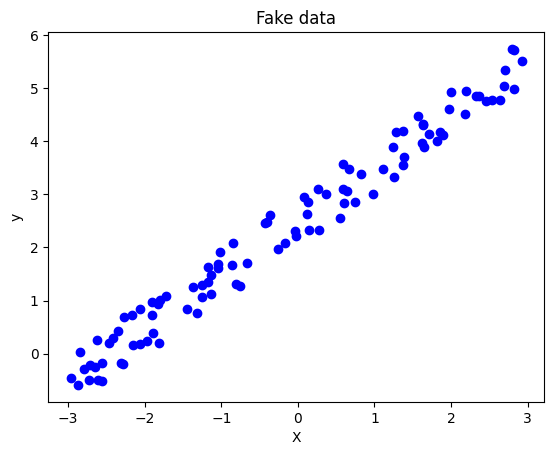

MSE: 0.08495655256593736
Your code PASSED the code check!


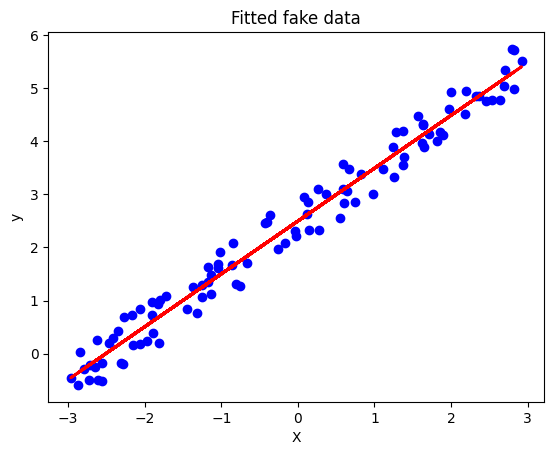

In [305]:
def TEST_OrdinaryLeastSquares():
    m = 100
    rng = np.random.RandomState(42)
    X = 6 * rng.rand(m, 1) - 3
    y = (2 + X) + rng.rand(m, 1)

    plt.plot(X, y, 'ob')
    plt.title("Fake data") # Synthetic data
    plt.xlabel("X")
    plt.ylabel("y")
    plt.show()

    X1 = np.hstack([np.ones((len(X), 1)), X])

    ols = OrdinaryLeastSquares()
    ols.fit(X1, y)
    preds = ols.predict(X1)
    mse_ = mse(y, preds)
    print(f"MSE: {mse_}")

    todo_check([
        (np.isclose(mse_, 0.08495, rtol=.01), "MSE value is potentially incorrect!"),
        (np.all(np.isclose(preds[:3].flatten(), [1.7482794, 5.18600448, 3.88101635], rtol=.01)), 'Your predictions possibly contain incorrect values!'),
        (np.all(np.isclose(ols.w.flatten(), [2.49683183, 0.99441139],  rtol=.01)), 'ols.w weights possibly contain incorrect values!')
    ])
    plt.title("Fitted fake data")
    plt.plot(X, y, 'ob')
    plt.plot(X, preds, '-r', linewidth=2)
    plt.xlabel("X")
    plt.ylabel("y")
    plt.show()

TEST_OrdinaryLeastSquares()
garbage_collect(['TEST_OrdinaryLeastSquares'])

##  Baseline: Linear OLS

Let's start off by developing a baseline. This will be just the basic linear OLS which we worked with in the prior lab.

### Training

#### TODO 10
Complete the TODO by getting our data, training the `OrdinaryLeastSquares` class and making predictions for our training and validation data.

1. Call the `data_prep()` function to get our cleaned and transformed data. Store the output into `data`. Make sure to pass `forestfire_df` and the arguments corresponding to the following descriptions:
    1. Return all data as NumPy arrays.
1. Create an instance of the `OrdinaryLeastSquares`. Store the output into `ols`.
1. Train the our `ols` instance using our training data `X_trn` and `y_trn`. Call the appropriate method and pass the required arguments.
1. After training, compute the predictions for the training data `X_trn`. Store the output into `y_hat_trn`.
1. Compute the predictions for the validation data `X_vld`. Store the output into `y_hat_vld`.

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
<ipython-input-301-bb7be834a626>:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  line = np.arange(y1,y2)


Training data size: (327, 30)
Validation data size: (82, 30)


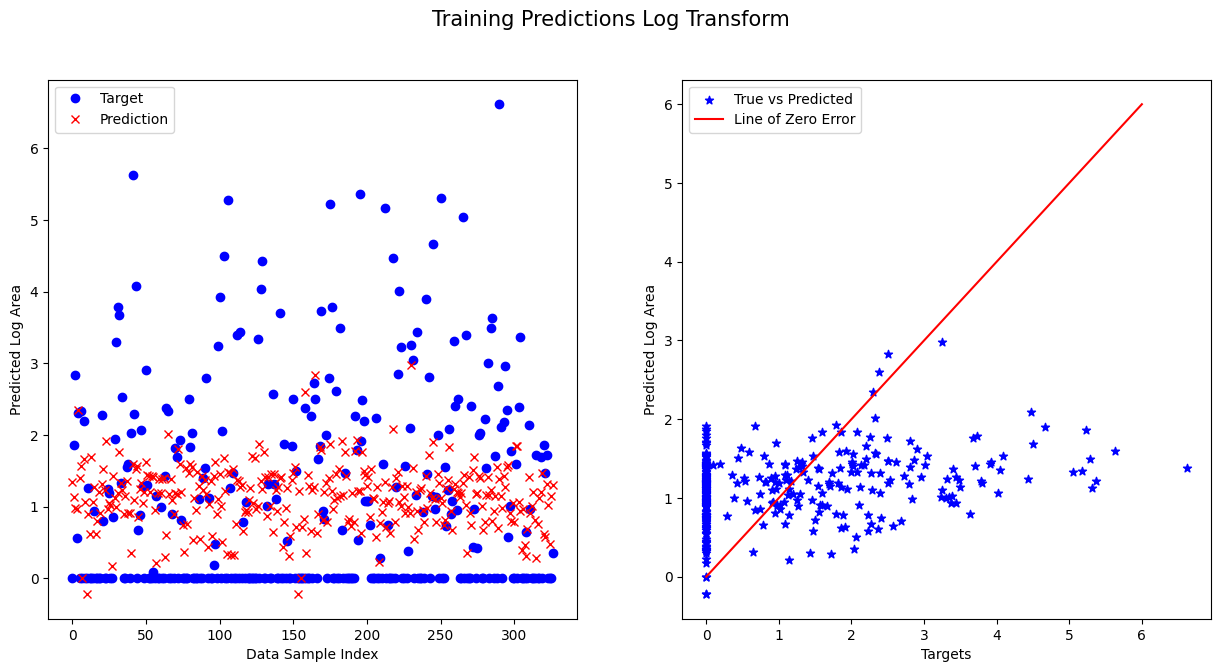

Training MSE: 1.7638848044418902
Training RMSE: 1.3281132498555575
Training SSE: 576.7903310524981

Training unlogged MSE: 4.8350614936582 ha
Training unlogged RMSE: 2.7739162291090556 ha
Your code PASSED the code check!


In [306]:
# TODO 10.1
data = data_prep(forestfire_df, poly_degree=2)

X_trn, y_trn, X_vld, y_vld, _, _, feature_names = data
X_trn = X_trn.to_numpy()
y_trn = y_trn.to_numpy()
X_vld = X_vld.to_numpy()
y_vld = y_vld.to_numpy()
print(f"Training data size: {X_trn.shape}")
print(f"Validation data size: {X_vld.shape}")

# TODO 10.2
ols = OrdinaryLeastSquares()

# TODO 10.3
ols.fit(X_trn, y_trn)

# TODO 10.4
y_hat_trn = ols.predict(X_trn)

_, trn_sse, trn_mse, trn_rmse = analyze(
    y=y_trn,
    y_hat=y_hat_trn,
    title="Training Predictions Log Transform",
    dataset="Training",
    xlabel="Data Sample Index",
    ylabel="Predicted Log Area"
);

todo_check([
    (isinstance(X_trn, np.ndarray), 'X_trn is not of type np.ndarray'),
    (np.isclose(trn_rmse, 1.32811, rtol=.01), "trn_rmse value is possibly incorrect!"),
    (np.all(np.isclose(ols.w[:3].flatten(), [1.1418673, -0.04806402, 0.02009187], rtol=0.01)), 'ols.w weights possibly contain incorrect values!')
])

### Validation

<ipython-input-301-bb7be834a626>:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  line = np.arange(y1,y2)


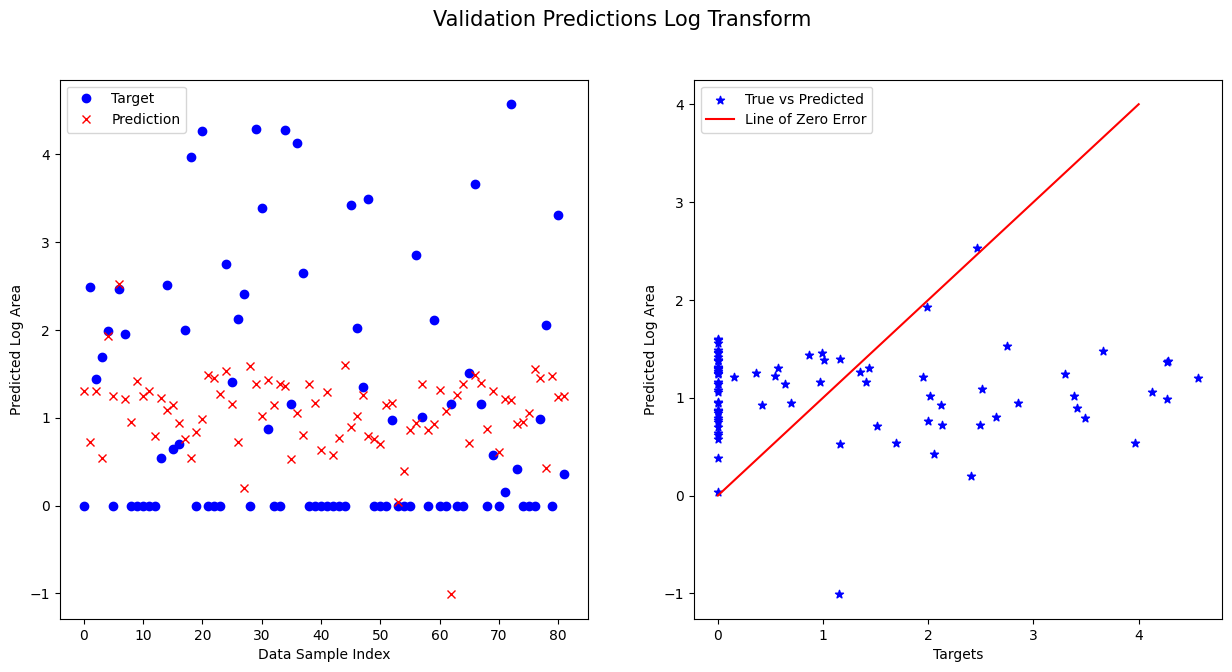

Validation MSE: 2.1567730073381677
Validation RMSE: 1.4685955901262158
Validation SSE: 176.85538660172975

Validation unlogged MSE: 7.643201060710927 ha
Validation unlogged RMSE: 3.3431313194241596 ha
Your code PASSED the code check!


In [307]:
# TODO 10.5
y_hat_vld = ols.predict(X_vld)

_, vld_sse, vld_mse, vld_rmse = analyze(
    y=y_vld,
    y_hat=y_hat_vld,
    title="Validation Predictions Log Transform",
    dataset="Validation",
    xlabel="Data Sample Index",
    ylabel="Predicted Log Area")

todo_check([
    (np.isclose(vld_mse, 2.1567, rtol=0.01), "vld_mse value is possibly incorrect!")
])

Below we add the validation scores and training hyperparameters, if any, to `scores`.

In [308]:
scores = {
    'ols': {},
    'lms': {}
}

if 'linear regression' not in scores['ols']:
    scores['ols']['linear regression'] = {
        'mse': vld_mse,
        'rmse': vld_rmse
    }

### Analyze weights

Next, let's take a look at our weight values. Recall, that for linear models we can roughly equate the absolution value of a weight to the importance of the weight. (Note that negative values don't hold any particular significance so we take the absolute value.) However, we can only say this if **all** our features are operating on the same scale. Since we standardized our data we can say this is approximately true!

With this idea of importance in mind, we can take the absolute value of our weights and sort them from largest to smallest and see what features our model is "valuing" the most. Below we define a function `rank_weights()` to do this for us.

In [309]:
def rank_weights(model, feature_names):
    """Rank the weights of the based model"""
    top_index = np.abs(model.w).argsort(axis=0)[::-1].flatten()
    df_w = pd.DataFrame(model.w[top_index],
                        index=feature_names[top_index],
                        columns=['weight'])

    return df_w

Take a second to review the value for each weight. Take note of the features that are being valued the most (features at the top) and the features that are being valued the least (features at the bottom). Further, we can ignore the bias as it is not a feature unique to our dataset!

In [310]:
rank_weights(ols, feature_names)

,weight
bias,1.141867
month_dec,0.196653
X,0.164240
temp,0.149554
wind,0.140224
DMC,0.129666
rain,-0.126947
day_thu,-0.126306
month_mar,-0.107182
month_oct,-0.100774


In [311]:
# Remove data variables for this section from memory
garbage_collect(['X_trn', 'y_trn', 'X_vld', 'y_vld','y_hat_trn', 'trn_sse', 'trn_mse', 'trn_rmse', 'y_hat_vld', 'vld_sse', 'vld_mse', 'vld_rmse', 'ols', 'data', 'feature_names'])

## Regularized Linear OLS

Next let's try regularizing our linear model. We don't expect this to do much but it can help use to further determine which weights might be useful. Recall that as we increase the value of $\lambda$ the values of the weights be driven towards zero. If we don't increase lambda too much, only the most important features have large weight values!

### Training

#### TODO 11
Complete the TODO by getting our data, training the `OrdinaryLeastSquares` class and making predictions for our training and validation data.

1. Call the `data_prep()` function to get our cleaned and transformed data. Store the output into `data`. Make sure to pass `forestfire_df` and the arguments corresponding to the following descriptions:
    1. Return all data as NumPy arrays.
1. Create an instance of the `OrdinaryLeastSquares` and pass the $\lambda = 10$ to the model using the `lamb` keyword argument. Store the output into `ols`.

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
<ipython-input-301-bb7be834a626>:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  line = np.arange(y1,y2)


Training data size: (327, 30)
Validation data size: (82, 30)


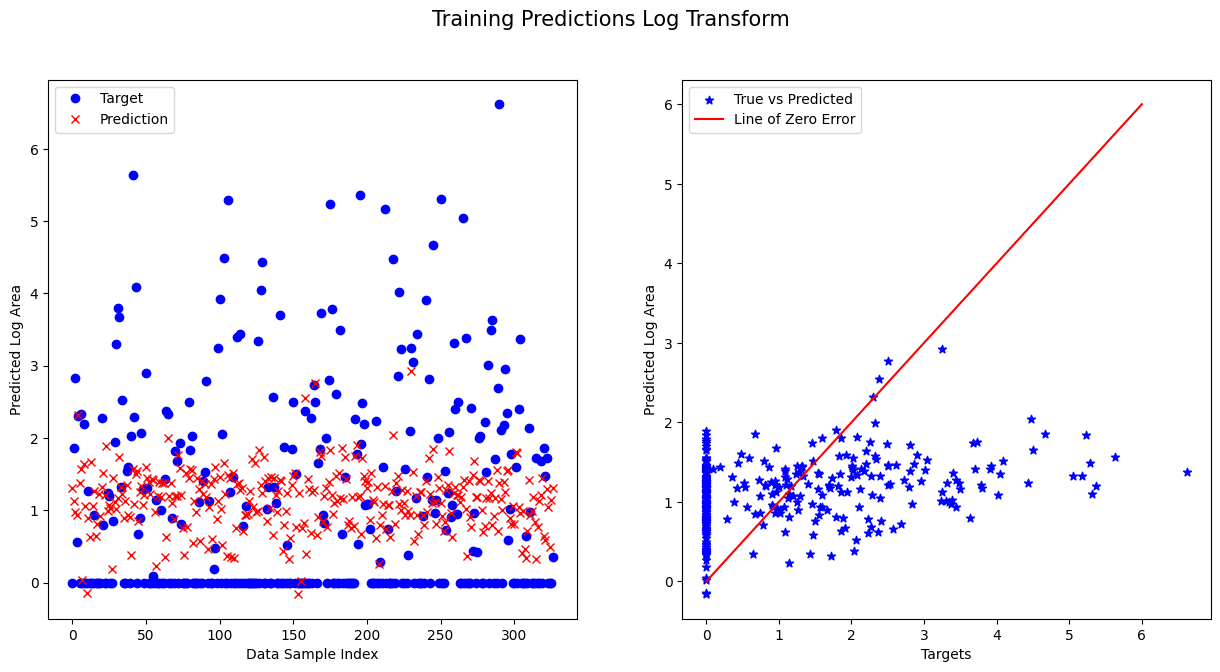

Training MSE: 1.7643821606077694
Training RMSE: 1.3283004782833474
Training SSE: 576.9529665187406

Training unlogged MSE: 4.837964319279629 ha
Training unlogged RMSE: 2.774622879661714 ha
Your code PASSED the code check!


In [312]:
# TODO 11.1
data = data_prep(forestfire_df, return_array=True)
X_trn, y_trn, X_vld, y_vld, _, _, feature_names = data

print(f"Training data size: {X_trn.shape}")
print(f"Validation data size: {X_vld.shape}")

# TODO 11.2
ols = OrdinaryLeastSquares(lamb=10)
ols.fit(X_trn, y_trn)

y_hat_trn = ols.predict(X_trn)

_, trn_sse, trn_mse, trn_rmse = analyze(
    y=y_trn,
    y_hat=y_hat_trn,
    title="Training Predictions Log Transform",
    dataset="Training",
    xlabel="Data Sample Index",
    ylabel="Predicted Log Area"
)

todo_check([
    (isinstance(X_trn, np.ndarray),'X_trn is not of type np.ndarray'),
    (np.isclose(trn_rmse, 1.32830, rtol=.01), "trn_rmse value is possibly incorrect!"),
    (np.all(np.isclose(ols.w[:3].flatten(), [1.14186730, -0.03448209, 0.01038472], rtol=0.01)), 'ols.w weights possibly contain incorrect values!')
])

### Validation

<ipython-input-301-bb7be834a626>:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  line = np.arange(y1,y2)


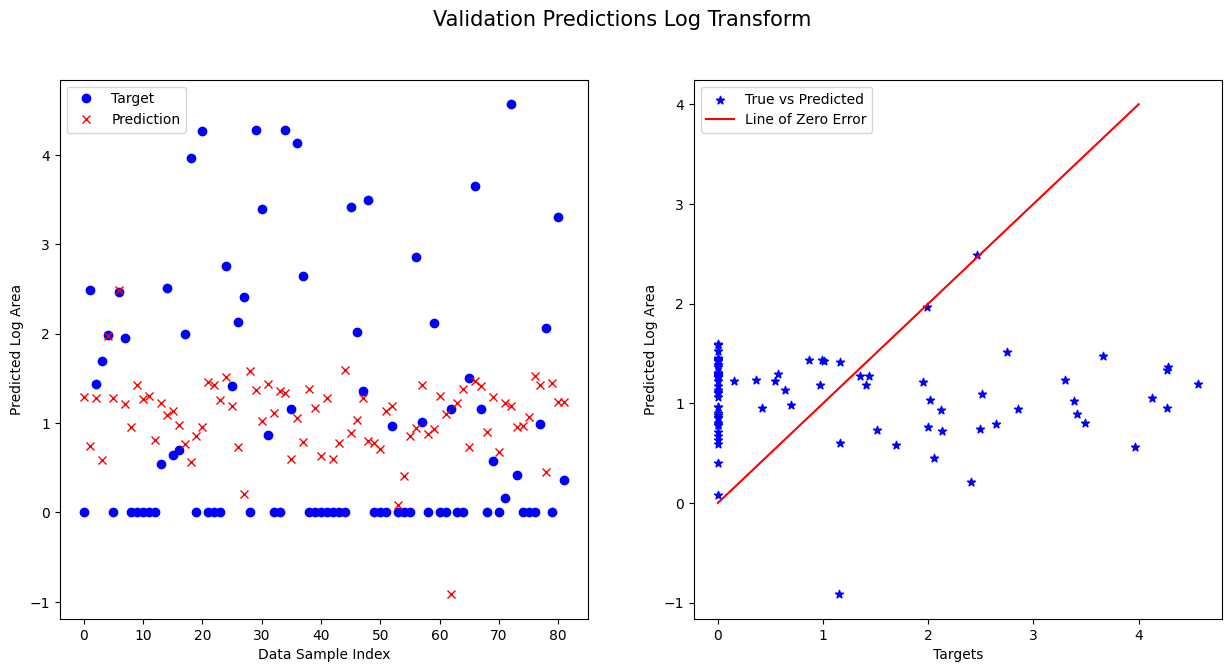

Validation MSE: 2.1503650778174697
Validation RMSE: 1.466412315079722
Validation SSE: 176.3299363810325

Validation unlogged MSE: 7.5879931107171945 ha
Validation unlogged RMSE: 3.333659412841927 ha


In [313]:
y_hat_vld = ols.predict(X_vld)

_, vld_sse, vld_mse, vld_rmse = analyze(
    y=y_vld,
    y_hat=y_hat_vld,
    title="Validation Predictions Log Transform",
    dataset="Validation",
    xlabel="Data Sample Index",
    ylabel="Predicted Log Area"
)

In [314]:
if 'regularized linear regression' not in scores['ols']:
    scores['ols']['regularized linear regression'] = {
        'mse': vld_mse,
        'rmse': vld_rmse,
        'lamb': ols.lamb
    }

Let's take a look at the scores so far. Notice, we haven't made much improvement over our linear regression baseline MSE and RMSE.

In [315]:
display_scores(scores)

Algorithm: ols
	Algorithm Type: linear regression
		mse : 2.1567730073381677
		rmse : 1.4685955901262158
	Algorithm Type: regularized linear regression
		mse : 2.1503650778174697
		rmse : 1.466412315079722
		lamb : 10

Algorithm: lms



### Analyzing weights

Looking at the weight values, notice that they have slightly shrunk in value. Sadly, the reduction in weight values has not been by a large amount and even if we increase the $\lambda$ to an extreme value like 500, the weights only decrease slightly more due to the nature of L2 norms diminishing.
 <!-- return at increasingly higher values of lambda. -->

*Normally, we would rather use the L1 Norm instead as it would completely drive our weight values to 0. However, we don't have time this week to cover it.*

In [316]:
rank_weights(ols, feature_names)

,weight
bias,1.141867
month_dec,0.189117
X,0.153351
wind,0.135238
temp,0.130563
day_thu,-0.122376
rain,-0.121915
month_oct,-0.108421
DMC,0.107802
month_jun,-0.086326


In [317]:
# Remove data variables for this section from memory
garbage_collect(['X_trn', 'y_trn', 'X_vld', 'y_vld','y_hat_trn', 'trn_sse', 'trn_mse', 'trn_rmse', 'y_hat_vld', 'vld_sse', 'vld_mse', 'vld_rmse', 'ols', 'data', 'feature_names'])

### Dropping features

Welp, let's at least try dropping some features that don't seem to be doing much like 'day', 'ISI', 'DC', 'RH', and 'FFMC' to see if it helps any.

**Training**
#### TODO 12
Complete the TODO by getting our data, training the `OrdinaryLeastSquares` class and making predictions for our training and validation data.

1. Call the `data_prep()` function to get our cleaned and transformed data. Store the output into `data`. Make sure to pass `forestfire_df` and the arguments corresponding to the following descriptions:
    1. Return all data as NumPy arrays.
    1. Drop the features 'day', 'ISI', 'DC', 'RH', and 'FFMC' from the data using the `drop_features` keyword argument.
1. Create an instance of the `OrdinaryLeastSquares` and pass the $\lambda = 10$ to the model using the `lamb` keyword argument. Store the output into `ols`.

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
<ipython-input-301-bb7be834a626>:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  line = np.arange(y1,y2)


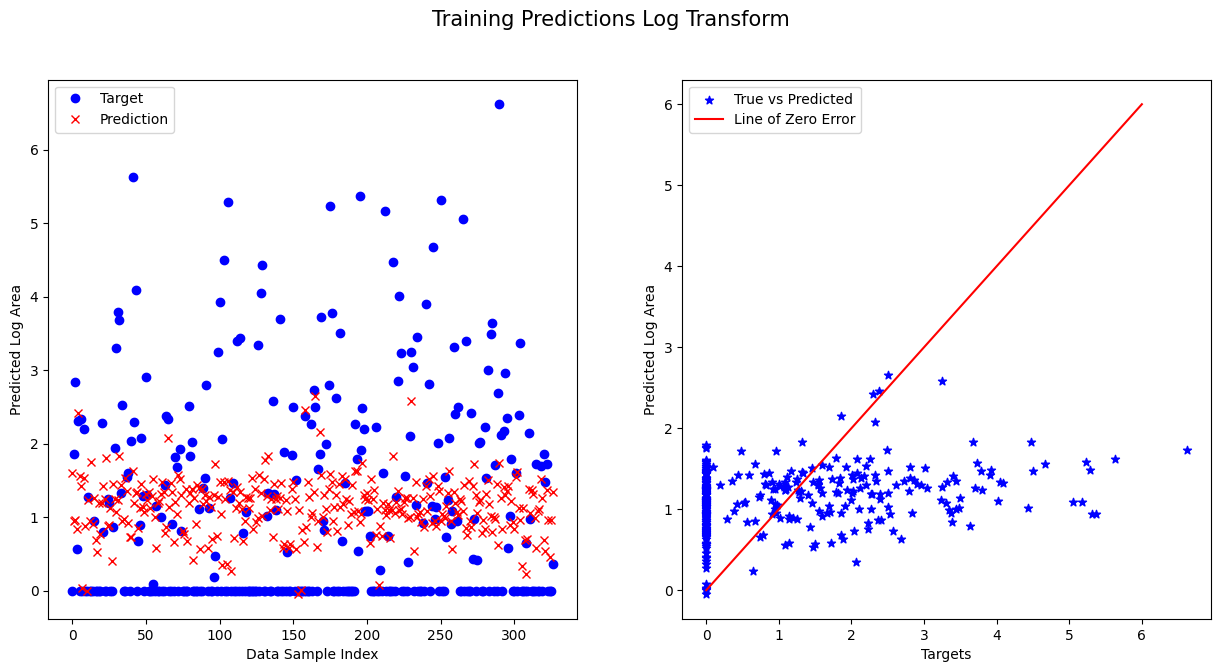

Training MSE: 1.7981781622785757
Training RMSE: 1.3409616557823627
Training SSE: 588.0042590650943

Training unlogged MSE: 5.03863602203717 ha
Training unlogged RMSE: 2.822717877093609 ha
Your code PASSED the code check!


In [318]:
# TODO 12.1
data = data_prep(forestfire_df, return_array=True, drop_features=['day', 'ISI', 'DC', 'RH', 'FFMC'])
X_trn, y_trn, X_vld, y_vld, _, _, feature_names = data

# TODO 12.2
ols = OrdinaryLeastSquares(lamb=10)

ols.fit(X_trn, y_trn)

y_hat_trn = ols.predict(X_trn)

_, trn_sse, trn_mse, trn_rmse = analyze(
    y=y_trn,
    y_hat=y_hat_trn,
    title="Training Predictions Log Transform",
    dataset="Training",
    xlabel="Data Sample Index",
    ylabel="Predicted Log Area"
)

todo_check([
    (isinstance(X_trn, np.ndarray), 'X_trn is not of type np.ndarray'),
    (np.isclose(trn_rmse, 1.34096, rtol=.01), "trn_rmse value is possibly incorrect!"),
    (np.all(np.isclose(ols.w[:3].flatten(), [ 1.1418, -0.03522, -0.0148 ], rtol=0.01)), 'ols.w weights possibly contain incorrect values!')
])

**Validation**

<ipython-input-301-bb7be834a626>:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  line = np.arange(y1,y2)


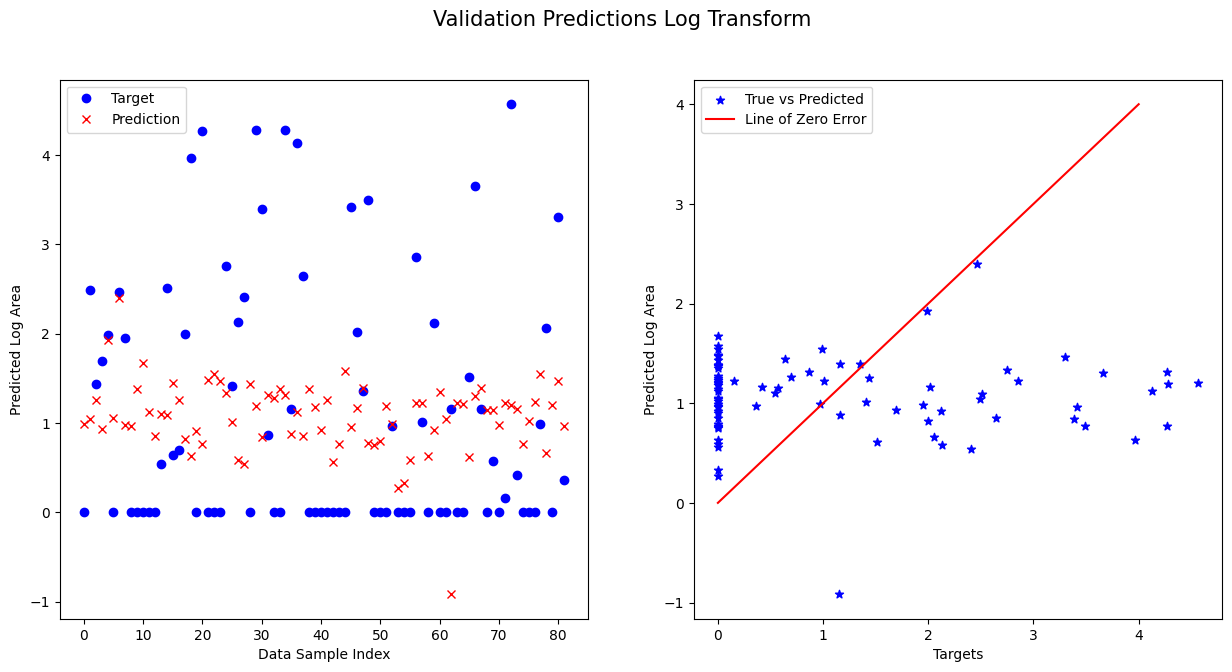

Validation MSE: 2.1167425446626655
Validation RMSE: 1.4549029330723977
Validation SSE: 173.57288866233856

Validation unlogged MSE: 7.304043332370817 ha
Validation unlogged RMSE: 3.2840676041392713 ha


In [319]:
y_hat_vld = ols.predict(X_vld)

_, vld_sse, vld_mse, vld_rmse = analyze(
    y=y_vld,
    y_hat=y_hat_vld,
    title="Validation Predictions Log Transform",
    dataset="Validation",
    xlabel="Data Sample Index",
    ylabel="Predicted Log Area"
)

In [320]:
if 'dropped features and regularized linear regression' not in scores['ols']:

    scores['ols']['dropped features and regularized linear regression'] = {
        'mse': vld_mse,
        'rmse': vld_rmse,
        "lamb": ols.lamb,
        "dropped":  ['day', 'ISI', 'DC', 'RH', 'FFMC']
    }

Once again, let's take a look at the scores so far. Hey look at that, we have slightly decreased our MSE and RMSE scores over the linear regression baseline and the regularized linear regression models, although not significantly.

In [321]:
display_scores(scores)

Algorithm: ols
	Algorithm Type: linear regression
		mse : 2.1567730073381677
		rmse : 1.4685955901262158
	Algorithm Type: regularized linear regression
		mse : 2.1503650778174697
		rmse : 1.466412315079722
		lamb : 10
	Algorithm Type: dropped features and regularized linear regression
		mse : 2.1167425446626655
		rmse : 1.4549029330723977
		lamb : 10
		dropped : ['day', 'ISI', 'DC', 'RH', 'FFMC']

Algorithm: lms



### Analyzing weights

Notice that even with the dropped features the weight ranking still remains relatively the same.

In [322]:
rank_weights(ols, feature_names)

,weight
bias,1.141867
month_dec,0.202256
temp,0.163020
X,0.152657
wind,0.132422
rain,-0.125598
month_jun,-0.100251
month_oct,-0.089271
DMC,0.082374
month_may,0.064231


In [323]:
# Remove data variables for this section from memory
garbage_collect(['X_trn', 'y_trn', 'X_vld', 'y_vld','y_hat_trn', 'trn_sse', 'trn_mse', 'trn_rmse', 'y_hat_vld', 'vld_sse', 'vld_mse', 'vld_rmse', 'ols', 'data', 'feature_names'])

## Polynomial OLS

Next, let's try **ONLY polynomial regression** using OLS and see if we can't do any better!

### Training

#### TODO 13
Complete the TODO by getting our data, training the `OrdinaryLeastSquares` class and making predictions for our training and validation data.

1. Call the `data_prep()` function to get our cleaned and transformed data. Store the output into `data`. Make sure to pass `forestfire_df` and the arguments corresponding to the following descriptions:
    1. Return all data as NumPy arrays.
    2. Transform the numerical features by passing the names of all the numerical features **EXCEPT** the categorical features 'month' and 'day'.
        1. Hint: You can specify this list of strings manually. If you want to do it automatically, you canuse Pandas `drop()` method on the `forestfire_df` in order to drop the 'area', 'month', and 'day' columns. Once dropped, you can then call the `columns` class variable to get the column names of the remaining numerical features.
    3. Transform the specified features using a degree 3 polynomial.
2. Create an instance of the `OrdinaryLeastSquares`. Store the output into `ols`.

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
<ipython-input-301-bb7be834a626>:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  line = np.arange(y1,y2)


Training data size: (327, 50)
Validation data size: (82, 50)
ols.w (first 3 weights): [ 1.1418673  -1.24585276  2.20733228]


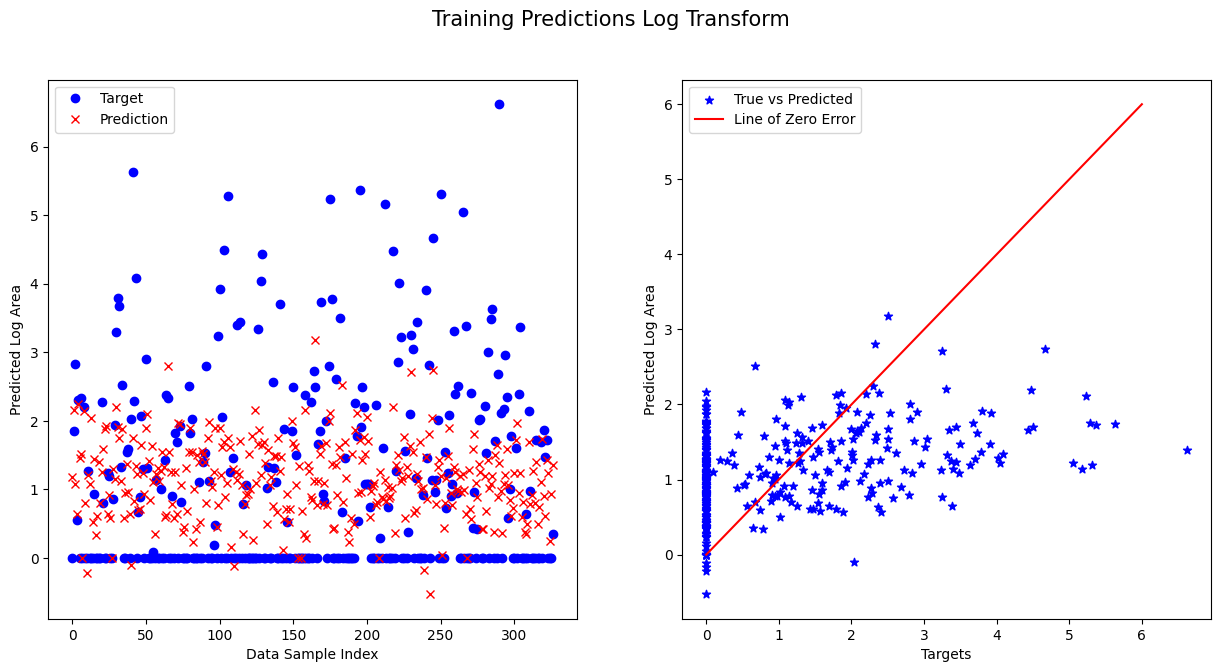

Training MSE: 1.634877428965395
Training RMSE: 1.2786232552888261
Training SSE: 534.6049192716841

Training unlogged MSE: 4.12882931258354 ha
Training unlogged RMSE: 2.591691477867619 ha
Your code PASSED the code check!


In [324]:
# TODO 13.1

num_features = forestfire_df.drop(columns=['area', 'month', 'day']).columns.tolist()

data = data_prep(
    forestfire_df,
    return_array=True,
    poly_col_names=num_features,
#     poly_col_names=['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'X', 'Y'],
    poly_degree=3
)

X_trn, y_trn, X_vld, y_vld, _, _, feature_names = data

X_trn = np.array(X_trn)
y_trn = np.array(y_trn)
X_vld = np.array(X_vld)
y_vld = np.array(y_vld)

print(f"Training data size: {X_trn.shape}")
print(f"Validation data size: {X_vld.shape}")

# TODO 13.2
ols = OrdinaryLeastSquares()

ols.fit(X_trn, y_trn)

print("ols.w (first 3 weights):", ols.w[:3].flatten())

y_hat_trn = ols.predict(X_trn)

_, trn_sse, trn_mse, trn_rmse = analyze(
    y=y_trn,
    y_hat=y_hat_trn,
    title="Training Predictions Log Transform",
    dataset="Training",
    xlabel="Data Sample Index",
    ylabel="Predicted Log Area"
)

todo_check([
    (isinstance(X_trn, np.ndarray), 'X_trn is not of type np.ndarray'),
    (np.isclose(trn_rmse, 1.27862, rtol=.01), "trn_rmse value is possibly incorrect!"),
    (np.all(np.isclose(ols.w[:3].flatten(), [ 1.1418673 , -1.24585276,  2.20733228], rtol=0.01)), 'ols.w weights possibly contain incorrect values!')
])

### Validation

Looking at the below validation MSE and RMSE we can see that even when using  a polynomial of degree 3 we see signs of overfitting as our validation MSE and RMSE increases over that of the training MSE and RMSE.

<ipython-input-301-bb7be834a626>:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  line = np.arange(y1,y2)


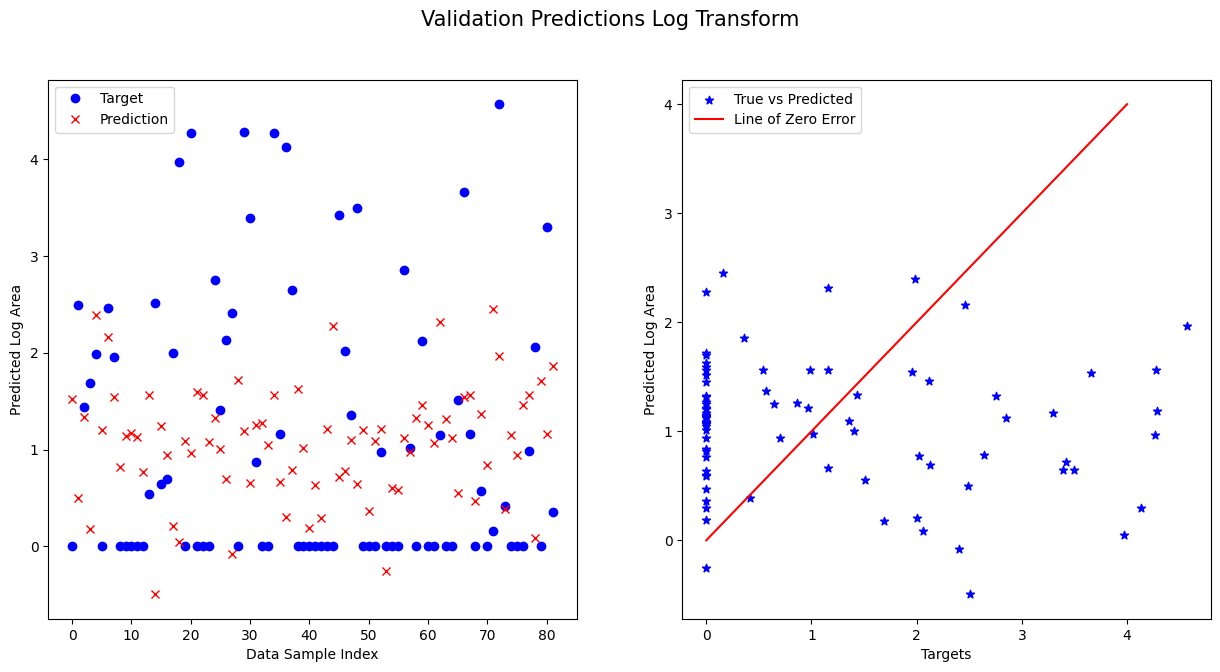

Validation MSE: 2.4756213996846066
Validation RMSE: 1.573410753644644
Validation SSE: 203.00095477413774

Validation unlogged MSE: 10.889092696614046 ha
Validation unlogged RMSE: 3.8230704768812362 ha


In [325]:
y_hat_vld = ols.predict(X_vld)

_, vld_sse, vld_mse, vld_rmse = analyze(
    y=y_vld,
    y_hat=y_hat_vld,
    title="Validation Predictions Log Transform",
    dataset="Validation",
    xlabel="Data Sample Index",
    ylabel="Predicted Log Area"
)

In [326]:
if 'polynomial regression' not in scores['ols']:

    scores['ols']['polynomial regression'] = {
        'mse': vld_mse,
        'rmse': vld_rmse,
        "poly_degree": 3,
        "poly_col_names": ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']
    }

Looking at the scores so far we can see normal polynomial regression with a degree 3 polynomial is actually doing worse than the previous algorithms.

In [327]:
display_scores(scores)

Algorithm: ols
	Algorithm Type: linear regression
		mse : 2.1567730073381677
		rmse : 1.4685955901262158
	Algorithm Type: regularized linear regression
		mse : 2.1503650778174697
		rmse : 1.466412315079722
		lamb : 10
	Algorithm Type: dropped features and regularized linear regression
		mse : 2.1167425446626655
		rmse : 1.4549029330723977
		lamb : 10
		dropped : ['day', 'ISI', 'DC', 'RH', 'FFMC']
	Algorithm Type: polynomial regression
		mse : 2.4756213996846066
		rmse : 1.573410753644644
		poly_degree : 3
		poly_col_names : ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']

Algorithm: lms



### Analyzing weights

Let's look at the weights once again. Interesting, look at how much the weight rankings have changed with the new polynomial features. **You can see FFMC and its polynomial transforms are now the most important and their weights are HUGE!** We can now clearly tell some regularization is needed as the weight values seem to be growing very large.

The FFMC has very different weights in linear regression and polynomial regression, which means the importance of a feature highly depends on the mchine learning model.

In [328]:
rank_weights(ols, feature_names)

,weight
FFMC^2,-82.584571
FFMC^3,42.516397
FFMC,40.106293
DMC^2,-4.249646
temp^2,4.090828
DMC,2.957395
DC^2,2.436448
temp,-2.335308
X^2,2.207332
ISI^2,-2.047641


In [329]:
# Remove data variables for this section from memory
garbage_collect(['X_trn', 'y_trn', 'X_vld', 'y_vld','y_hat_trn', 'trn_sse', 'trn_mse', 'trn_rmse', 'y_hat_vld', 'vld_sse', 'vld_mse', 'vld_rmse', 'ols', 'data', 'feature_names'])

## Regularized Polynomial OLS

Lastly, let's try some **regularized polynomial** OLS using ridge regression.

### Training

#### TODO 14
Complete the TODO by getting our data, training the `OrdinaryLeastSquares` class and making predictions for our training and validation data.

1. Call the `data_prep()` function to get our cleaned and transformed data. Make sure to pass `forestfire_df` and the arguments corresponding to the following descriptions:
    1. Return all data as NumPy arrays.
    1. Transform the numerical features by passing the names of all the numerical features **EXCEPT** the categorical features 'month' and 'day'.
        1. Hint: You can specify this list of strings manually or automatically generate it by using Pandas `drop()` method on the `forestfire_df` and dropping the 'area', 'month', and 'day' columns. Once dropped, you can then call the `columns` class variable to get the column names of the remaining numerical features.
    1. Transform the specified features using a degree 3 polynomial.
1. Create an instance of the `OrdinaryLeastSquares` and pass $\lambda = 3$ to the model using the `lamb` keyword argument. Store the output into `ols`.

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
<ipython-input-301-bb7be834a626>:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  line = np.arange(y1,y2)


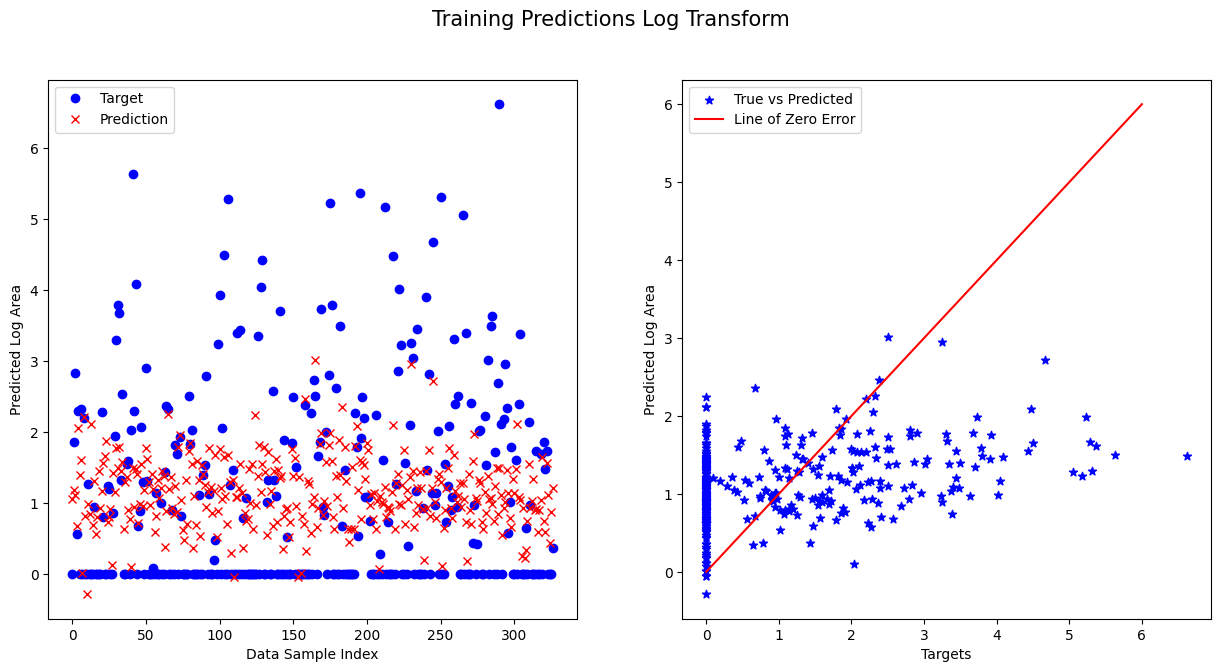

Training MSE: 1.6765453550350415
Training RMSE: 1.2948147956503437
Training SSE: 548.2303310964586

Training unlogged MSE: 4.347051861170488 ha
Training unlogged RMSE: 2.6503198564181876 ha
Your code PASSED the code check!


In [330]:
# TODO 14.1
data = data_prep(forestfire_df,
    return_array=True,
    poly_col_names=forestfire_df.drop(['area', 'month', 'day'], axis=1).columns,
    poly_degree=3
)
X_trn, y_trn, X_vld, y_vld, _, _, feature_names = data

# TODO 14.2
ols = OrdinaryLeastSquares(lamb=3)

ols.fit(X_trn, y_trn)

y_hat_trn = ols.predict(X_trn)

_, trn_sse, trn_mse, trn_rmse = analyze(
    y=y_trn,
    y_hat=y_hat_trn,
    title="Training Predictions Log Transform",
    dataset="Training",
    xlabel="Data Sample Index",
    ylabel="Predicted Log Area"
)

todo_check([
    (isinstance(X_trn, np.ndarray), 'X_trn is not of type np.ndarray'),
    (np.isclose(trn_rmse, 1.294814, rtol=.01), "trn_rmse value is possibly incorrect!"),
    (np.all(np.isclose(ols.w[:3].flatten(), [ 1.1418673 , -0.37070008,  0.2762113 ], rtol=0.01)), 'ols.w weights possibly contain incorrect values!')
])

### Validation

<ipython-input-301-bb7be834a626>:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  line = np.arange(y1,y2)


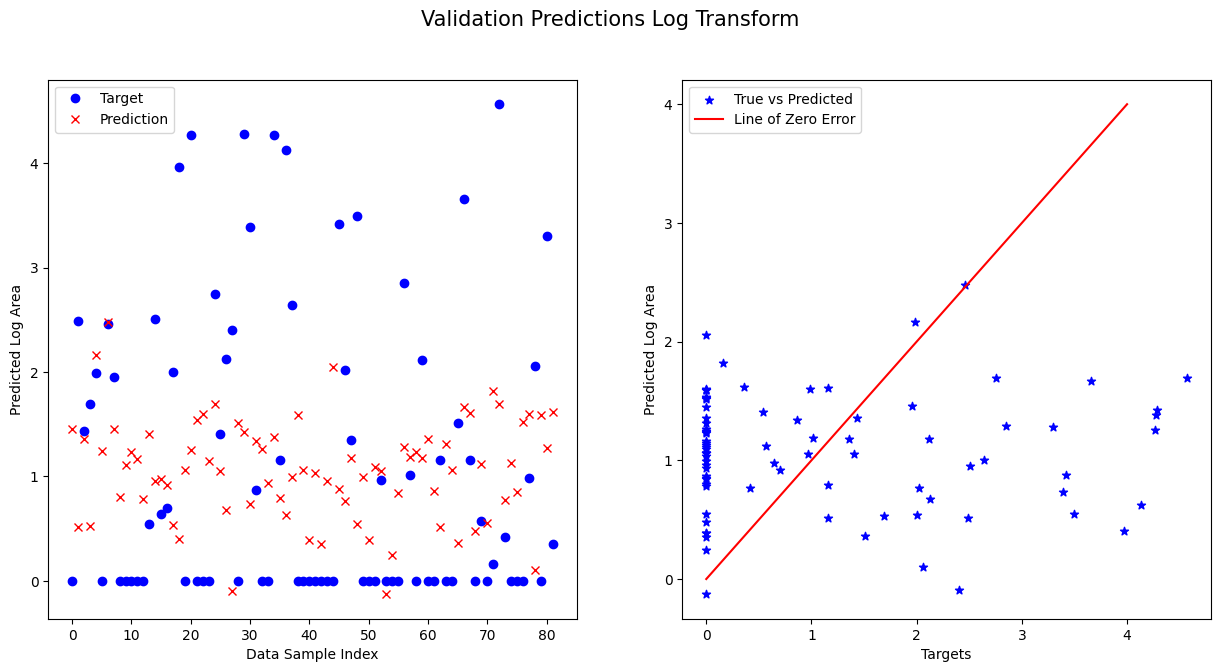

Validation MSE: 2.1629784541004375
Validation RMSE: 1.470706787262654
Validation SSE: 177.36423323623586

Validation unlogged MSE: 7.697002743841397 ha
Validation unlogged RMSE: 3.3523102116450785 ha


In [331]:
y_hat_vld = ols.predict(X_vld)

_, vld_sse, vld_mse, vld_rmse = analyze(
    y=y_vld,
    y_hat=y_hat_vld,
    title="Validation Predictions Log Transform",
    dataset="Validation",
    xlabel="Data Sample Index",
    ylabel="Predicted Log Area"
)

In [332]:
if 'regularized polynomial regression' not in scores['ols']:

    scores['ols']['regularized polynomial regression'] = {
        'mse': vld_mse,
        'rmse': vld_rmse,
        "lamb": ols.lamb,
        "poly_degree": 3,
        "poly_col_names":  ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']
    }

Nice, looking at the scores so far, notice we have gotten the polynomial regression with regularization MSE and RMSE scores down to around the same values as the other OLS types.

In [333]:
display_scores(scores)

Algorithm: ols
	Algorithm Type: linear regression
		mse : 2.1567730073381677
		rmse : 1.4685955901262158
	Algorithm Type: regularized linear regression
		mse : 2.1503650778174697
		rmse : 1.466412315079722
		lamb : 10
	Algorithm Type: dropped features and regularized linear regression
		mse : 2.1167425446626655
		rmse : 1.4549029330723977
		lamb : 10
		dropped : ['day', 'ISI', 'DC', 'RH', 'FFMC']
	Algorithm Type: polynomial regression
		mse : 2.4756213996846066
		rmse : 1.573410753644644
		poly_degree : 3
		poly_col_names : ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']
	Algorithm Type: regularized polynomial regression
		mse : 2.1629784541004375
		rmse : 1.470706787262654
		lamb : 3
		poly_degree : 3
		poly_col_names : ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']

Algorithm: lms



### Analyzing weights

Ahhh, notice that our weight values have shrunk significantly due to our regularization! Now we can see 'bias' is back at the top as 'FFMC' and its polynomial features were likely causing some overfitting.

In [334]:
rank_weights(ols, feature_names)

,weight
bias,1.141867
DMC,0.552396
temp,-0.519476
X,-0.370700
ISI^3,0.366939
ISI,-0.350653
X^3,0.334615
FFMC,0.288557
temp^3,0.278800
X^2,0.276211


In [335]:
# Remove data variables for this section from memory
garbage_collect(['X_trn', 'y_trn', 'X_vld', 'y_vld','y_hat_trn', 'trn_sse', 'trn_mse', 'trn_rmse', 'y_hat_vld', 'vld_sse', 'vld_mse', 'vld_rmse', 'ols', 'data', 'feature_names'])

## Scores so far

Below we review the validation metrics and hyperparameters for each type of OLS we have used so far!  Notice that all the validation RMSE and MSE scores for all the types of OLS we have tried so far are all relatively similar. This might be indicating that we are reaching the limit of the OLS when using either linear or non-linear methods. However, we could try doing some hyper-parameter tuning but this lab is already running long so we'll try that in future labs.  

In [336]:
display_scores(scores)

Algorithm: ols
	Algorithm Type: linear regression
		mse : 2.1567730073381677
		rmse : 1.4685955901262158
	Algorithm Type: regularized linear regression
		mse : 2.1503650778174697
		rmse : 1.466412315079722
		lamb : 10
	Algorithm Type: dropped features and regularized linear regression
		mse : 2.1167425446626655
		rmse : 1.4549029330723977
		lamb : 10
		dropped : ['day', 'ISI', 'DC', 'RH', 'FFMC']
	Algorithm Type: polynomial regression
		mse : 2.4756213996846066
		rmse : 1.573410753644644
		poly_degree : 3
		poly_col_names : ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']
	Algorithm Type: regularized polynomial regression
		mse : 2.1629784541004375
		rmse : 1.470706787262654
		lamb : 3
		poly_degree : 3
		poly_col_names : ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']

Algorithm: lms



Welp, we probably wont improve much using least mean squares (LMS) as LMS will approximate the same weights given by OLS. However, let's try implementing LMS with ridge regression to practice!

# Least Mean Squares using Polynomial and Ridge Regression

Next, let's practice *Least Means Squares (LMS)*. However, instead of using the *online gradient descent* update rule, let's use the **mini-batch gradient descent** update rule with regularization!  First recall that LMS is an iterative linear regression algorithm that aims to approximate the same solution as OLS. Further, recall that the following equation is the *mini-batch gradient descent* update rule for slowly moving our weights towards achieving the smallest training error and the most optimal weights:

$$
\begin{align}
\wv_{k+1} &=  \wv_{k} - \alpha \nabla J(\wv_{k}) \\
&= \wv_{k} - \alpha \Big [ \frac{1}{\text{mb}} \sum_{i=1}^{\text{mb}}( {\wv_{k}}^\top \xv_i - y_i) \xv_i  + \lambda \wv_{k}  \Big ]
\\
&= \wv_{k} - \alpha \Big [ \frac{1}{\text{mb}} \sum_{i=1}^{\text{mb}}( \hat{y}_i - y_i) \xv_i  + \lambda \wv_{k}  \Big ] \\
&= \wv_{k} - \alpha \Big [ \frac{1}{\text{mb}} ( \hat{\yv}_{\text{mb}} - \yv_{\text{mb}}) \Xm_{\text{mb}}  + \lambda \wv_{k}  \Big ] \\
&= \wv_{k} - \alpha \Big [ \frac{1}{\text{mb}} \Xm_{\text{mb}}^\top ( \hat{\yv}_{\text{mb}} - \yv_{\text{mb}})  + \lambda \wv_{k}  \Big ]
\end{align}
$$

where in this equation
- $\text{mb}$ refers to the number of samples in a given mini-batch (i.e., mini-batch size)
- $i$ now indexes to the current data sample in the mini-batch.
- $\wv_k$ is the current weight vector where each element corresponding to an input feature.
- $\wv_{k+1}$ indicates the weights after being updated using the current average gradient of the mini-batch.
- $\xv_i$ is the current data samples in the mini-batch.
- $y_i$ is the current target for the data sample in the mini-batch.
- $\alpha$ is the learning rate that determines how big of a step to take in the direction of the average gradient.
- $\lambda$ is the regularization term that determines how much the **L2 norm** should affect the cost function.
- $\yv_{\text{mb}}$ current mini-batch of labels
- $\hat{\yv}_{\text{mb}}$ current mini-batch of predictions
- $\Xm_{\text{mb}}$ current mini-batch of data samples

## Generating mini-batches

Below is a function for pre-determining the mini-batches for our data. Notice all it is does is randomly split the **indexes** of the data into groups equal to the size of the mini-batch size (a hyperparameter determined by you).

In [337]:
def get_mini_batches(data_len: int,
                     batch_size: int = 32) -> List[np.ndarray]:
    """ Generates mini-batches based on the data indexes

        Args:
            data_len: Length of the data or number of data samples
                in the data.

            batch_size: Size of each mini-batch where the last mini-batch
                might be smaller than the rest if the batch_size does not
                evenly divide the data length.
    """
    X_idx = np.arange(data_len)
    np.random.shuffle(X_idx)
    batches = [X_idx[i:i+batch_size] for i in range(0, data_len, batch_size)]

    return batches

Let's try calling the function to get a better understanding of it's output

#### TODO 15
Complete the TODO by calling the `get_mini_batches()` and observing its output.

1. Call the `get_mini_batches()` function and pass the length of the `X_trn` data and a batch size of 32. Store the output into `batches`.

*Notice that every time we run the below code the indexes in each mini-batch change. This is part of the reason mini-batch gradient descent is also used interchangeably with stochastic gradient descent as we are randomly selecting data samples for each mini-batch every epoch.*

In [338]:
X_trn, y_trn, X_vld, y_vld, _, _, feature_names = data_prep(forestfire_df)

# TODO 15.1
batches = get_mini_batches(len(X_trn), batch_size=32)
display(batches)

todo_check([
    (len(batches[-1]) == 7, 'batches returned the wrong number of mini-batches')
])

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[array([235,  10,  36,  17, 298, 299, 134,  30, 142, 107, 244,  59, 266,
         41, 242,  22,  66,  90, 128, 239, 325, 158, 219, 233, 159, 141,
        109,  44, 304,  20, 135, 269]),
 array([164,  55, 221, 294, 196, 207, 232, 277, 222, 318, 252, 139,  60,
        228, 160, 250, 210,  33, 271, 260, 165,  91, 229, 105,  43, 293,
        144, 195, 323, 301,  76, 130]),
 array([264, 116,  54, 275,  25, 154, 274, 273, 175,  34, 284, 206,  70,
        202, 297, 203, 143, 192, 106, 308, 149,  27, 172, 181, 209, 129,
        246,  97, 237, 230,  89,   7]),
 array([136,  73, 204,  81, 295,  28,  19,  92, 124, 183, 199, 243,  86,
         78, 157, 300, 251, 218, 303, 245, 263, 265,  93,  65, 177,  85,
         18, 104, 256,  49,  61, 286]),
 array([176, 155, 117, 288, 320, 312,   4,  96, 171, 169, 316,  74,  52,
        217,  11, 283, 123, 151, 170, 262, 113, 118,   6,  71, 234, 114,
        261, 119,   1, 309,  94, 147]),
 array([ 88, 185, 249, 291, 307,  63,  12, 173,  79,  26, 200, 280, 12

Your code PASSED the code check!


Notice the last mini-batch is not 32 samples. This is because the size 32 does not evenly divide the length of our training data! Some libraries will automatically drop this last mini-batch though it is not required.

In [339]:
batches[-1]

array([198, 187, 108, 281,  75,  98, 148])

Using  `X_trn`, can easily index ALL the data samples for the 1st mini-batch of data samples by using the first element in `batches` as follows.

In [340]:
first_batch = batches[0]
print(f"Below are the indexes for the 1st mini-batch:\n{first_batch}")
X_trn.iloc[first_batch]

Below are the indexes for the 1st mini-batch:
[235  10  36  17 298 299 134  30 142 107 244  59 266  41 242  22  66  90
 128 239 325 158 219 233 159 141 109  44 304  20 135 269]


,bias,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,...,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain
235,1,-0.124611,-0.776493,-0.136717,-0.219265,-0.055385,-0.234177,-0.147902,-0.351726,-0.078446,...,-1.594983,-1.854546,0.501008,0.375111,0.642721,0.070226,0.615051,-0.660559,-1.047362,-0.085642
10,1,-0.124611,-0.776493,-0.136717,-0.219265,-0.055385,-0.234177,-0.147902,-0.351726,-0.078446,...,-1.164653,0.551948,0.425196,-0.990778,0.585173,-0.031272,-0.558061,-0.600625,-1.784748,-0.085642
36,1,-0.124611,1.287842,-0.136717,-0.219265,-0.055385,-0.234177,-0.147902,-0.351726,-0.078446,...,-0.303994,-0.250217,1.233857,0.601502,0.318323,1.237460,2.290925,-1.439704,0.257244,-0.085642
17,1,-0.124611,-0.776493,-0.136717,-0.219265,-0.055385,-0.234177,-0.147902,2.843120,-0.078446,...,-0.734324,0.551948,-0.711983,-1.304706,-1.875209,-1.300004,-0.641855,-0.420822,-0.763752,-0.085642
298,1,-0.124611,-0.776493,-0.136717,-0.219265,-0.055385,-0.234177,-0.147902,-0.351726,-0.078446,...,-0.734324,-0.250217,0.046136,-0.361412,0.742445,-0.158145,0.682086,0.058651,-0.026366,-0.085642
299,1,-0.124611,-0.776493,-0.136717,-0.219265,-0.055385,-0.234177,6.761234,-0.351726,-0.078446,...,1.847653,0.551948,0.602091,-0.945500,-0.968234,1.288210,1.553540,-0.660559,0.257244,-0.085642
134,1,-0.124611,-0.776493,-0.136717,-0.219265,-0.055385,-0.234177,-0.147902,-0.351726,-0.078446,...,-1.164653,-0.250217,0.374655,-0.095781,0.846505,0.247849,1.034019,-1.080099,-1.047362,-0.085642
30,1,-0.124611,1.287842,-0.136717,-0.219265,-0.055385,-0.234177,-0.147902,-0.351726,-0.078446,...,0.986994,-0.250217,0.652632,0.411334,0.200468,2.886812,-2.284211,3.055362,0.994630,-0.085642
142,1,-0.124611,-0.776493,-0.136717,-0.219265,-0.055385,-0.234177,-0.147902,-0.351726,-0.078446,...,0.986994,-0.250217,0.374655,-0.095781,0.846505,0.247849,1.101054,-1.080099,-0.763752,-0.085642
107,1,-0.124611,1.287842,-0.136717,-0.219265,-0.055385,-0.234177,-0.147902,-0.351726,-0.078446,...,0.556665,0.551948,1.284398,0.225694,0.107050,1.922576,0.782638,-0.720494,0.257244,-0.085642


In [341]:
# Remove data variables for this section from memory
garbage_collect(['X_trn', 'y_trn', 'X_vld', 'y_vld', 'batches', 'first_batch', 'feature_names'])

#### **TODO 16 (Important!)**
Complete the TODO by finishing the `LeastMeanSquares` class such that it utilizes mini-batches and regularization. Reference the LMS algorithm in the linear regression notes for help on some of the TODOs as the implementation will be similar but still quite different.


**Tips**:

- There are many different ways of implementing this algorithm correctly. The instructions will try to guide you towards one potential implementation!


- Programming implementations don't always correspond 1-1 with the mathematical equations! Sometimes terms are changed around or transposed!


- **Check the shapes of all your NumPy arrays**. You will most likely run into shape mismatch, matmul, and broadcasting issues when implementing this code! Refer to the print statements which help you to debug your shape issues in code! The goal here is to practice troubleshooting these errors.
    - Please also refer back to Module 1's lab to review shape mismatch, matmul, and broadcasting errors and how to debug them!


- Making all your arrays 2D will cause you less headaches when it comes to broadcasting, shape mismatch, or matmul errors. Remember a 2D means it has 2 dimensions. Take the example of a random array that has 5 elements. It can be represented either as a 1D or 2D array in NumPy as seen below:
    - 1D array has the shape (5,)
    - 2D array has the shape (5, 1) or (1, 5)
        - A column vector has the shape (5, 1)
        - A row vector has the shape (1, 5)
        - Notice this is the same as the 1D array but we explicitly defined a 1 either in the 1st or 2nd dimension. This is what we mean when we say a 2D vector (a 2D array where one a dimension is equal to 1, either in the row or column dimension)!
    - To make a 1D array into a 2D array you can use the `.reshape()` method. For instance, if our weights `self.w` had the shape $(n,)$ we could use the`.reshape()` method add a dimension by doing the following: `self.w = self.w.reshape(-1, 1)` ([post on meaning for (-1, 1)](https://stackoverflow.com/questions/18691084/what-does-1-mean-in-numpy-reshape)) giving us the new shape $(n ,1)$.
    - To switch the dimensions of an array we can also use the `.reshape()` method. For instance, if our weights `self.w` had the shape $(1, n)$  we could use the`.reshape()` method switch the row and column dimensions by doing the following: `self.w = self.w.reshape(-1, 1)` giving us the new shape $(n ,1)$.

**TODO 16.1 for `predict()`**

1. First, complete the `self.predict()` method to which returns the prediction between our input data `X` and weights `self.w`. We'll be using this method to complete our `fit()` method as well!

   > 1. Hint: Recall, we use the dot product to between the weights `self.w` and the passed data `X` to make a prediction. You might have to adjust the order of whether the weights or data comes first to avoid shape mismatch or matmul errors!

**TODO 16.2 for `fit()`: Setting the weights**

2. Initialize the weights `self.w` randomly using our instance variable `rng` of NumPy's `np.random.RandomState` class and use `rng.rand()` ([docs](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.RandomState.rand.html#numpy.random.RandomState.rand)) method to create a column vector of shape $(n, 1)$ where $n$ is the number of features/columns in our data `X` (1 weight for each feature including the bias term). Store the output back into our class variable `self.w`. Pass the arguments that correspond to the following descriptions:
    1. The first argument ALWAYS corresponds to size of the 1st dimension (i.e., the number of rows). Set this equal to the number of features/columns $n$ in our data `X`.
    1. The second  argument ALWAYS corresponds to size of the 2nd dimension (i.e., the number of columns). Set this equal to 1 since we want a 2D column vector!


**TODOs 16.3-16.4 for `fit()`: Getting mini-batches and predictions**

3. Pre-compute the mini-batch indexes by using the `get_mini_batches()`function. Store the output in `batch_indexes`. Pass the arguments that correspond to the following descriptions:
    1. Number of data samples in `X` (try finding the length of `X`).
    1. The size of each mini-batch (refer to the `LeastMeanSquares` class variables).

4. Compute the predictions for the **CURRENT mini-batch** by indexing `X` by `mb` and calling the `self.predict()` method. Store the output into `y_hat`.

**TODOs 16.5-16.7 for `fit()`: Computing the average mini-batch gradient**

5. Compute the L2 norm derivative $\lambda\wv_k$. Store the output into `l2_norm`.
    1. Hint: Recall $\lambda$ refers to our class variable `self.lamb`.

6. Compute the gradient and store the output into `gradient`. Use the below equation to compute the gradient:
$$
\begin{align}
J(\wv_{k}) &= \Xm_{\text{mb}}^\top (\Xm_{\text{mb}} \wv_{k} - \yv_{\text{mb}}) + \lambda \wv_{k} \\
&= \Xm_{\text{mb}}^\top (\hat{\yv}_\text{mb}- \yv_{\text{mb}}) + \lambda \wv_{k}
\end{align}
$$

  > Hint: Recall $\Xm_{\text{mb}} \wv_{k} = \hat{\yv}_\text{mb}$. This means we can just use the variable `y_hat` which already holds the output of $\Xm_{\text{mb}} \wv_{k}$.

  > Hint: Recall $\lambda \wv_{k}$ refers to the `l2_norm` variable we just set!


7. Compute the average gradient by dividing by the number of data samples in the mini-batch (i.e., the length of the mini-batch). Store the output into `avg_gradient`.
$$
J(\wv_{k}) = \frac{1}{\text{mb}} J(\wv_{k})
$$

**TODO 16.8 for `fit()`: Updating the weights**

8. Update the weights using the average gradient as shown in the below equation. Store the output into `self.w`.
$$
\wv_{k+1} = \wv_{k} - \alpha \nabla J(\wv_{k})
$$

    1. Hint: Recall $\nabla J(\wv_{k})$ refers to our gradient in this case `avg_gradient`.
    1. Hint: Recall $\alpha$ refers to our learning rate stored in the class variable `self.alpha`.

In [342]:
import IPython.display as ipd  # for display and clear_output

class LeastMeanSquares():
    """
        Performs regression using least mean squares (gradient descent)

        attributes:
            w (np.ndarray): weight matrix

            alpha (float): learning rate or step size

            lamb (float): Regularization parameter for controlling
                L2 regularization.

            batch_size(int): Size of mini-batches for mini-batch gradient
                descent.

            epochs (int): Number of epochs to run for mini-batch
                gradient descent

            seed (int): Seed to be used for NumPy's RandomState class
                or universal seed np.random.seed() function.
    """


    def __init__(
        self,
        alpha: float = .01,
        lamb: float = 0,
        batch_size: int = 32,
        epochs: int = 1,
        seed: int = None
    ):
        self.w = None
        self.alpha = alpha
        self.lamb = lamb
        self.epochs = epochs
        self.seed = seed
        self.batch_size = batch_size

        self.fig = plt.figure(figsize=(10,5))
        self.trn_err_hist = []

    def predict(self, X: np.ndarray):
        # Predict output by multiplying input features with weights
        return X.dot(self.w)

    def fit(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        # Set global seed for mini-batch reproducibility
        np.random.seed(self.seed)

        # Set rnd with seed for weight reproducibility
        rng = np.random.RandomState(self.seed)
        # TODO 16.2
        self.w = rng.randn(X.shape[1], 1)

        print("Initial Shape check...")
        print(f"\t X shape: {X.shape}")
        print(f"\t y shape: {y.shape}")
        print(f"\t w shape: {self.w.shape}")

        for e in range(self.epochs):
            # TODO 16.3
            batch_indexes = np.array_split(np.random.permutation(len(X)), len(X) // self.batch_size + 1)

            for mb in batch_indexes:
                print(f"\ty[mb] shape: {y[mb].shape}")
                print(f"\tX[mb, :] shape: {X[mb].shape}")
                print(f"\tself.w: {self.w.shape}")

                # TODO 16.4
                y_hat = X[mb].dot(self.w)
                print(f"\ty_hat shape: {y_hat.shape}")

                # TODO 16.5
                l2_norm = y_hat - y[mb]
                print(f"\tl2_norm shape: {l2_norm.shape}")

                # TODO 16.6
                gradient = X[mb].T.dot(l2_norm)
                print(f"\tgradient shape: {gradient.shape}")

                # TODO 16.7
                avg_gradient = gradient / len(mb)
                print(f"\tavg_gradient shape: {avg_gradient.shape}")

                # TODO 16.8
                self.w = self.w - self.alpha * avg_gradient
                print(f"\tself.w shape AFTER update: {self.w.shape}")

                # Checking predictions and RMSE performance
                # of training data.
                preds = self.predict(X)
                print(f"\tpreds: {preds.shape}")

                trn_rmse = rmse(preds, y)
                self.trn_err_hist.append(trn_rmse)

                # Plot error every minibatch
                self._plot_rmse_hist()


    def _plot_rmse_hist(self):
        # Training RMSE tracking (left graph)
        plt.subplot(1, 2, 1)
        plt.plot(self.trn_err_hist)
        plt.ylabel(f"Training RMSE")
        plt.xlabel("Mini-Batches Trained")
        plt.title(f"RMSE Learning Curve - Current RMSE: {self.trn_err_hist[-1]}")

        # clear display
        ipd.clear_output(wait=True)
        ipd.display(self.fig)
        plt.clf()

Run the `TEST_LeastMeanSquares()` function to test your `LeastMeanSquares` class implementation. Here we use synthetic data.

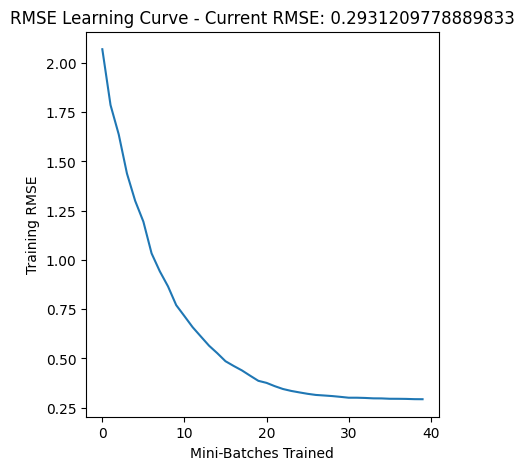

Final weights: [2.46581019 0.99083847]
Your code PASSED the code check!


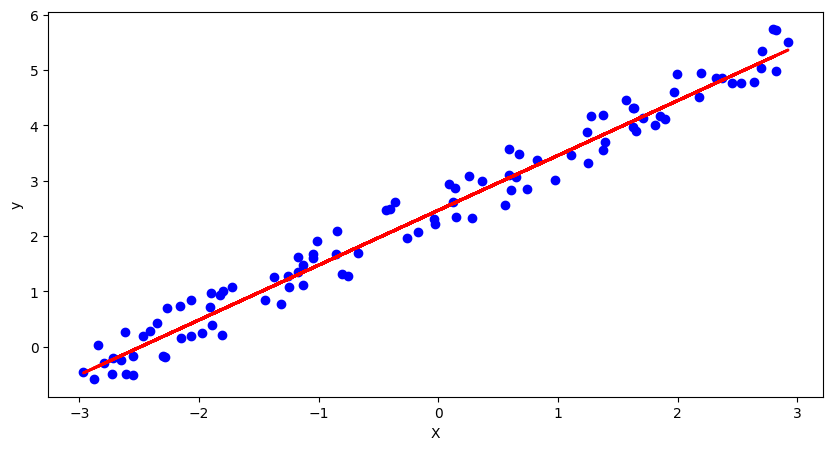

In [343]:
def TEST_LeastMeanSquares():
    m = 100
    rng = np.random.RandomState(42)
    X = 6 * rng.rand(m, 1) - 3
    y = (2 + X) + rng.rand(m, 1)

    X1 = np.hstack([np.ones((len(X), 1)), X])

    lms = LeastMeanSquares(
        alpha=.1,
        lamb=.01,
        batch_size=32,
        epochs=10,
        seed=42
    )
    lms.fit(X1, y)
    preds = lms.predict(X1)
    print(f"Final weights: {lms.w.flatten()}")

    todo_check([
        (np.isclose(rmse(y, preds), .30, rtol=.1), "Train RMSE value is potentially incorrect!"),
        (np.all(np.isclose(lms.w.flatten(), [2.429, 1.015],  rtol=.1)), 'lms.w values are possibly incorrect!')
    ])

    plt.plot(X, y, 'ob')
    plt.plot(X, preds, '-r', linewidth=2)
    plt.xlabel("X")
    plt.ylabel("y")
    plt.show();

TEST_LeastMeanSquares()
garbage_collect(['TEST_LeastMeanSquares'])

The first graph plotted above by the `LeastMeanSquares` class is referred to as a *learning curve* plot. Our learning curve plot graphs the total training RMSE for ALL the training data samples after every mini-batch. Overtime this allows us to see how the training RMSE changes. If we use the right hyperparameters we should see the RMSE value converge to a local minimum. We can see this convergence to a local minimum as the RMSE score begins to flatten out. We'll take a deeper look at learning curve plots in the near future.

## Regularized Polynomial LMS

Instead of retrying all the different types of algorithm variations like we did for OLS, let's just focus on regularized polynomial regression for LMS to see if we can't approximate the same MSE and RMSE scores the OLS version was able to achieve.

### Training

#### TODO 17
Complete the TODO by getting our data, training the `LeastMeanSquares` class and making predictions for our training and validation data.

1. Call the `data_prep()` function to get our cleaned and transformed data. Store the output into `data`. Make sure to pass `forestfire_df` and the arguments corresponding to the following descriptions:
    1. Return all data as NumPy arrays.
    2. Transform the numerical features by passing the names of all the numerical features **EXCEPT** the categorical features 'month' and 'day'.
        1. Hint: You can specify this list of strings manually, or automatically generate it by using Pandas `drop()` method on the `forestfire_df` and dropping the 'area', 'month', and 'day' columns. Once dropped, you can then call the `columns` class variable to get the column names of the remaining numerical features.
    3. Transform the specified features using a degree 3 polynomial.
2. Create an instance of the `LeastMeanSquares` and pass the following arguments as specified below. Store the output into `lms`.
    1. Pass the lambda or $$\lambda = .2$$
    2. Pass a learning rate or $\alpha = .1$
    3. Pass 12 epochs
    4. Pass a batch size of 128
    5. Pass a seed of 42

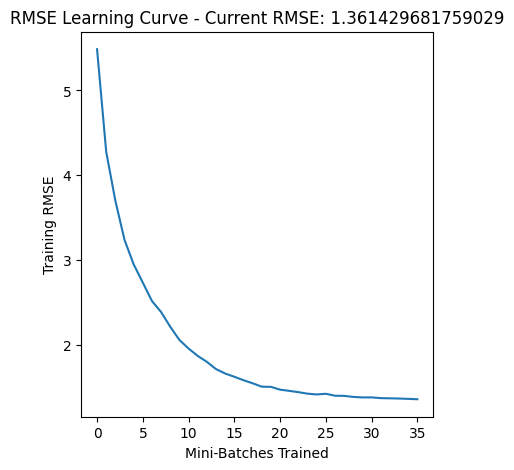

<ipython-input-301-bb7be834a626>:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  line = np.arange(y1,y2)


<Figure size 1000x500 with 0 Axes>

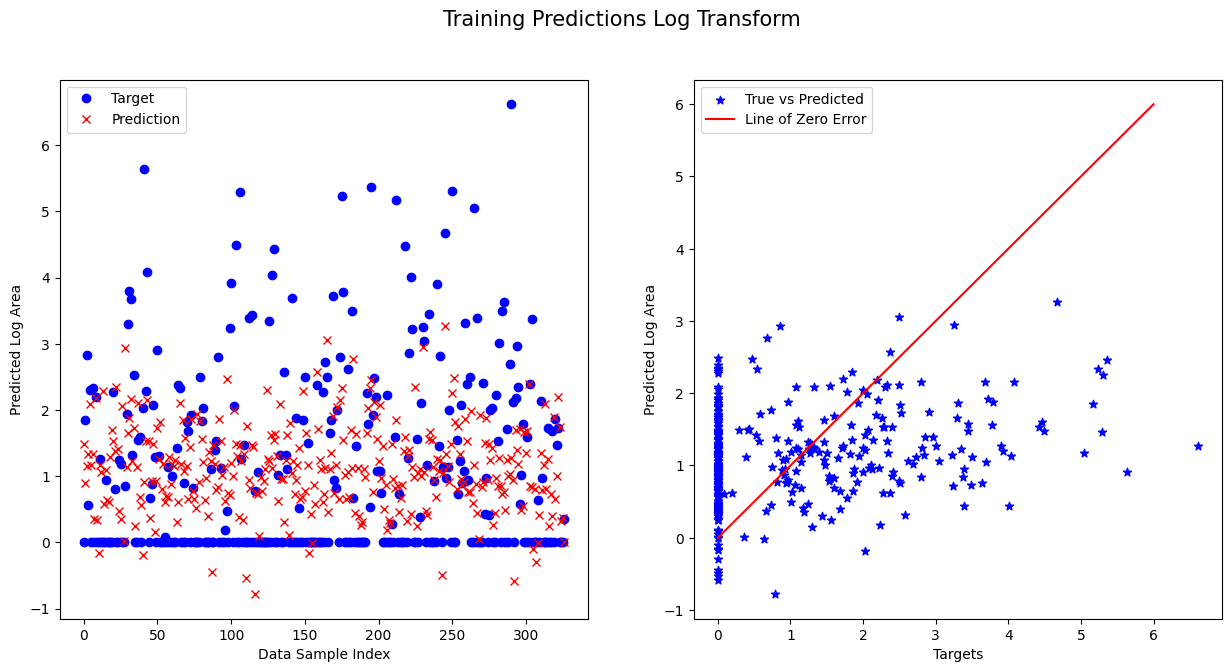

Training MSE: 1.853490778374491
Training RMSE: 1.361429681759029
Training SSE: 606.0914845284585

Training unlogged MSE: 5.38205903708174 ha
Training unlogged RMSE: 2.901767602076674 ha


AssertionError: You passed 1/2 and FAILED the following code checks:
Failed check [2]:
	 Tip: lms.w values are possibly incorrect!

In [356]:
# TODO 17.1
data = data_prep(
    forestfire_df,
    return_array=True,
    poly_col_names=forestfire_df.drop(['area', 'month', 'day'], axis=1).columns,
    poly_degree=3
)
X_trn, y_trn, X_vld, y_vld, _, _, feature_names = data

X_trn = np.array(X_trn)
y_trn = np.array(y_trn)
X_vld = np.array(X_vld)
y_vld = np.array(y_vld)

# TODO 17.2
lms = LeastMeanSquares(lamb=0.2, alpha=0.1, epochs=12, batch_size=128, seed=42)

lms.fit(X_trn, y_trn)

y_hat_trn = lms.predict(X_trn)

_, trn_sse, trn_mse, trn_rmse = analyze(
    y=y_trn,
    y_hat=y_hat_trn,
    title="Training Predictions Log Transform",
    dataset="Training",
    xlabel="Data Sample Index",
    ylabel="Predicted Log Area"
)

todo_check([
    (np.isclose(trn_rmse, 1.36, rtol=.1), 'trn_rmse value is potentially incorrect!'),
    (np.all(np.isclose(lms.w.flatten()[:3], [0.950, 0.072, 0.051],  rtol=.1)) or np.all(np.isclose(lms.w.flatten()[:3], [1.12, 0.129,  0.045],  rtol=.1)) , 'lms.w values are possibly incorrect!')
])


### Validation

Notice, in the below predictions a data sample is being predicted as a negative value that is far away from the other predictions. This is a good indicator that there is a data sample in our validation set that contains values our algorithm hasn't seen before or hasn't properly learned. It also could be an outlier we missed!

If we were to continue learning for more epochs we would see that the LMS model becomes more conservative in its predictions, thus predicting a smaller negative value for this data sample. If you look back at the prior predictions for each model you'll also see some very small negative values are predicted.

<ipython-input-301-bb7be834a626>:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  line = np.arange(y1,y2)


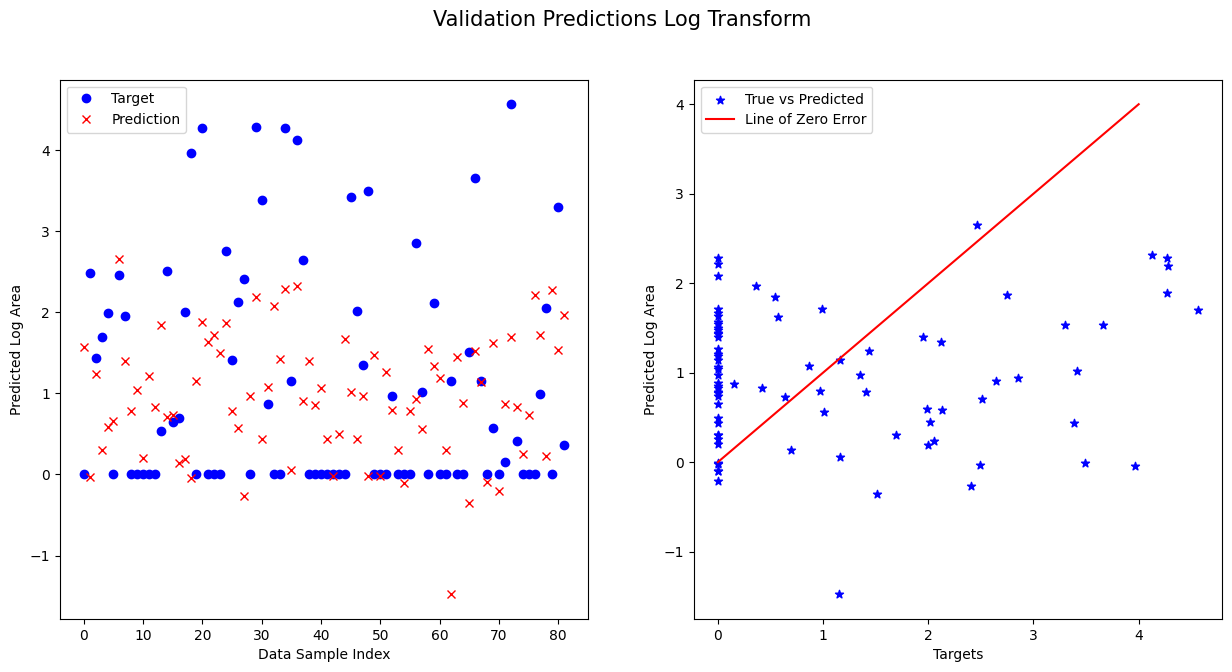

Validation MSE: 2.2942115761656283
Validation RMSE: 1.514665499760798
Validation SSE: 188.12534924558153

Validation unlogged MSE: 8.916614434155044 ha
Validation unlogged RMSE: 3.547899598880406 ha


In [345]:
y_hat_vld = lms.predict(X_vld)

_, vld_sse, vld_mse, vld_rmse = analyze(
    y=y_vld,
    y_hat=y_hat_vld,
    title="Validation Predictions Log Transform",
    dataset="Validation",
    xlabel="Data Sample Index",
    ylabel="Predicted Log Area"
)

In [346]:
if 'regularized polynomial regression' not in scores['lms']:

    scores['lms']['regularized polynomial regression'] = {
        'mse': vld_mse,
        'rmse': vld_rmse,
        "alpha": lms.alpha,
        "lamb": lms.lamb,
        "batch_size": lms.batch_size,
        "epochs": lms.epochs,
        "poly_degree": 3,
        "poly_col_names":  ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']
    }

Looking at the scores so far, notice that we have have gotten our regularized polynomial regression using LMS to around the same MSE and RMSE values as the other OLS types, although we still have some room for improvement. Potentially, fine-tuning our learning rate $\alpha$, regularization term $\lambda$, number of epochs, and batch size might be needed to achieve the same MSE and RMSE values.

In [347]:
display_scores(scores)

Algorithm: ols
	Algorithm Type: linear regression
		mse : 2.1567730073381677
		rmse : 1.4685955901262158
	Algorithm Type: regularized linear regression
		mse : 2.1503650778174697
		rmse : 1.466412315079722
		lamb : 10
	Algorithm Type: dropped features and regularized linear regression
		mse : 2.1167425446626655
		rmse : 1.4549029330723977
		lamb : 10
		dropped : ['day', 'ISI', 'DC', 'RH', 'FFMC']
	Algorithm Type: polynomial regression
		mse : 2.4756213996846066
		rmse : 1.573410753644644
		poly_degree : 3
		poly_col_names : ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']
	Algorithm Type: regularized polynomial regression
		mse : 2.1629784541004375
		rmse : 1.470706787262654
		lamb : 3
		poly_degree : 3
		poly_col_names : ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']

Algorithm: lms
	Algorithm Type: regularized polynomial regression
		mse : 2.2942115761656283
		rmse : 1.514665499760798
		alpha : 0.1
		lamb : 0.2
		batch_size : 128
		epochs : 1

### Analyzing weights

Below we can see that LMS seems to be valuing the month and day features more than other features.

In [348]:
rank_weights(lms, feature_names)

,weight
temp^2,1.529455
temp,-1.389613
bias,1.127571
month_mar,-0.925958
wind^2,-0.853124
DC,-0.830407
RH^2,-0.816007
X^3,0.808000
ISI^2,0.798941
DC^2,-0.780904


In [349]:
# Remove data variables for this section from memory
garbage_collect(['X_trn', 'y_trn', 'X_tst', 'y_tst','y_hat_trn', 'trn_sse', 'trn_mse', 'trn_rmse', 'y_hat_tst', 'tst_sse', 'tst_mse', 'tst_rmse', 'ols', 'data', 'feature_names'])

# Reviewing Model Performance

Welp, if we review the final scores we can see that we really couldn't crack a validation RMSE score below ~1.45. To improve models further, we might want to really dive into our features and figure our which ones are truly the "best" and further fine tune our hyper-parameters.

Further, we might want to reconsider our features in general as they don't really show any linear or non-linear trends. Additionally, we could consider more complex models like neural networks or deep neural networks!

In [350]:
display_scores(scores)

Algorithm: ols
	Algorithm Type: linear regression
		mse : 2.1567730073381677
		rmse : 1.4685955901262158
	Algorithm Type: regularized linear regression
		mse : 2.1503650778174697
		rmse : 1.466412315079722
		lamb : 10
	Algorithm Type: dropped features and regularized linear regression
		mse : 2.1167425446626655
		rmse : 1.4549029330723977
		lamb : 10
		dropped : ['day', 'ISI', 'DC', 'RH', 'FFMC']
	Algorithm Type: polynomial regression
		mse : 2.4756213996846066
		rmse : 1.573410753644644
		poly_degree : 3
		poly_col_names : ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']
	Algorithm Type: regularized polynomial regression
		mse : 2.1629784541004375
		rmse : 1.470706787262654
		lamb : 3
		poly_degree : 3
		poly_col_names : ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']

Algorithm: lms
	Algorithm Type: regularized polynomial regression
		mse : 2.2942115761656283
		rmse : 1.514665499760798
		alpha : 0.1
		lamb : 0.2
		batch_size : 128
		epochs : 1

## Testing our best model

For now, let's choose the regularized polynomial regression with OLS algorithm as our best model. Even though it doesn't achieve the lowest score, with enough fine-tuning it could achieve the same scores as the other models since the other best performing models are simple linear models. Recall regularized polynomial regression can be reduced to a linear model if too many degrees aren't used and the regularization term is large enough.

### Training

Before utilizing your test set it is common practice to combine the training and validation set into a new training set and then use said larger training set to train a new model using your best model. Once trained, we can then analyze the model using our test set.

#### TODO 18
Complete the TODO by combing our training and validation features and targets.

1. Combine both the `X_trn` and `X_vld` datasets into one dataset using NumPy's `vstack()` function ([docs](https://numpy.org/doc/stable/reference/generated/numpy.vstack.html)). Store the output into `X_trn`.
2. Combine both the `y_trn` and `y_vld` datasets into one dataset using NumPy's `vstack()` function. Store the output into `y_trn`.

In [351]:
poly_col_names = forestfire_df.drop(['area', 'month', 'day'], axis=1).columns
data = data_prep(forestfire_df,
                 poly_degree=3,
                 poly_col_names=poly_col_names,
                 return_array=True)
X_trn, y_trn, X_vld, y_vld, X_tst, y_tst, feature_names = data

# TODO 18.1
X_trn = np.vstack((X_trn, X_vld))
# TODO 18.2
y_trn = np.vstack((y_trn, y_vld))

print(f"Training data shape: {X_trn.shape}")
print(f"Training target shape: {y_trn.shape}")

todo_check([
    (X_trn.shape == (409, 50),'X_trn does not have the correct shape of (409, 50)'),
    (y_trn.shape == (409, 1),'y_trn does not have the correct shape of (409, 1)')
])

Training data shape: (409, 50)
Training target shape: (409, 1)
Your code PASSED the code check!


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


<ipython-input-301-bb7be834a626>:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  line = np.arange(y1,y2)


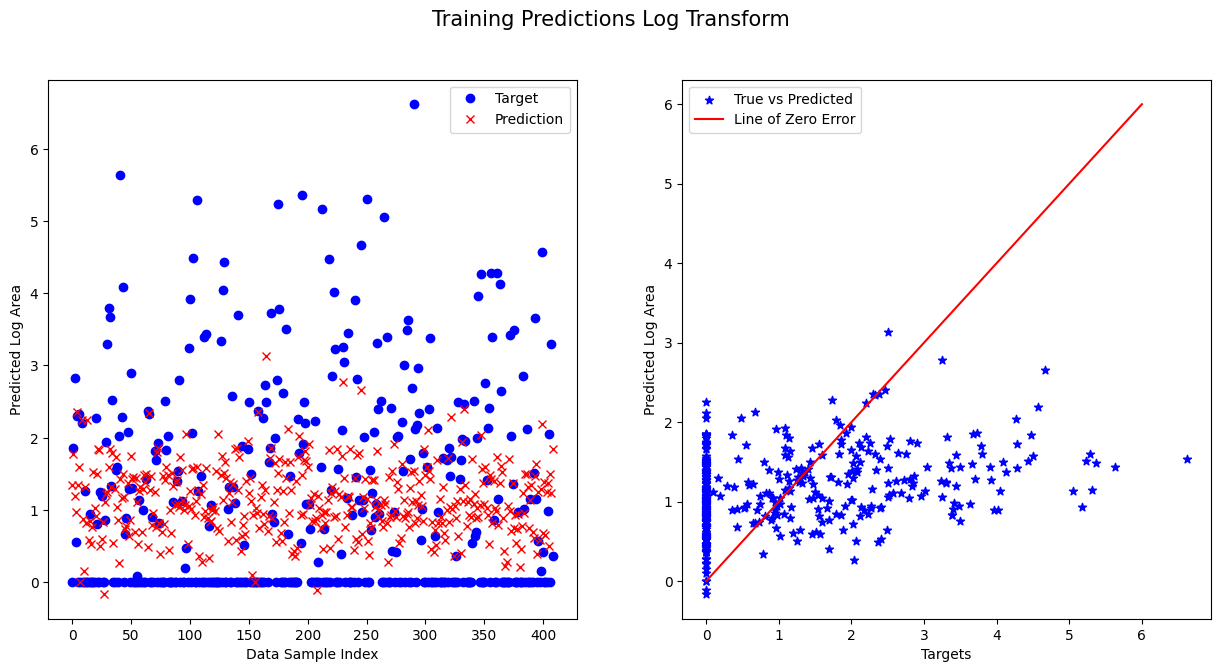

Training MSE: 1.714262772776841
Training RMSE: 1.309298580453229
Training SSE: 701.1334740657279

Training unlogged MSE: 4.552580489570057 ha
Training unlogged RMSE: 2.703575041010657 ha


In [352]:
ols = OrdinaryLeastSquares()

ols.fit(X_trn, y_trn)

y_hat_trn = ols.predict(X_trn)

_, trn_sse, trn_mse, trn_rmse = analyze(
    y=y_trn,
    y_hat=y_hat_trn,
    title="Training Predictions Log Transform",
    dataset="Training",
    xlabel="Data Sample Index",
    ylabel="Predicted Log Area"
)

### Testing

<ipython-input-301-bb7be834a626>:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  line = np.arange(y1,y2)


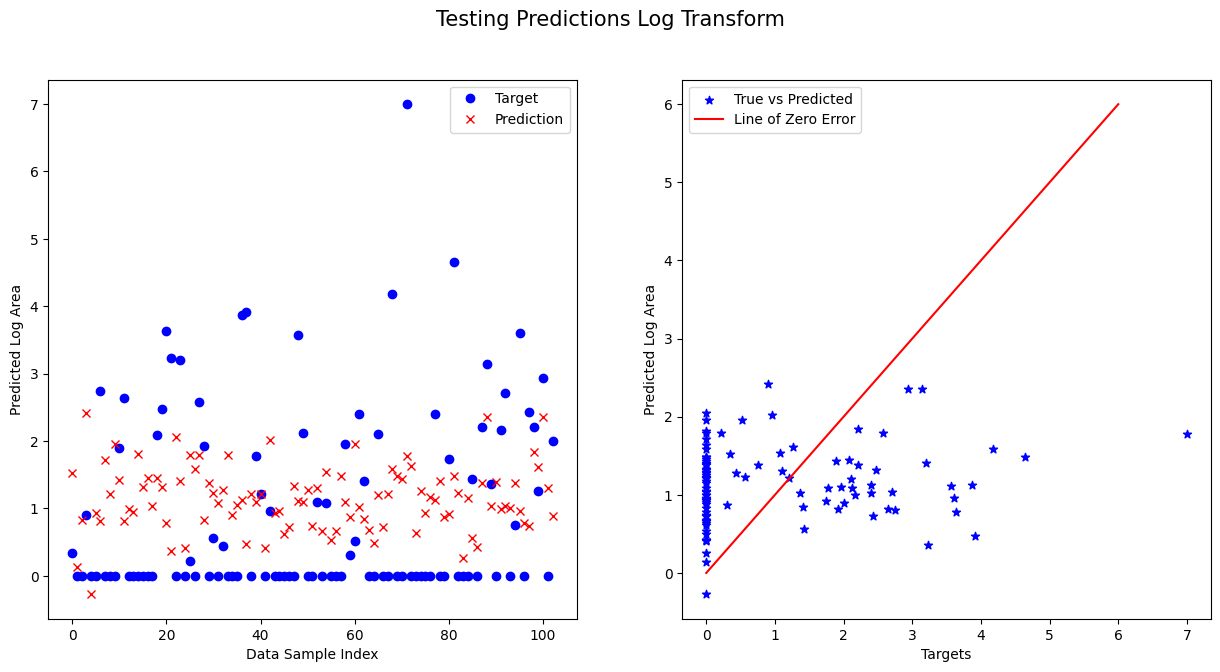

Test MSE: 2.0268545287301842
Test RMSE: 1.4236764129289297
Test SSE: 208.766016459209

Test unlogged MSE: 6.590174096275525 ha
Test unlogged RMSE: 3.15235819630535 ha


In [353]:
y_tst_hat = ols.predict(X_tst)

_, tst_sse, tst_mse, tst_rmse = analyze(
    y=y_tst,
    y_hat=y_tst_hat,
    title="Testing Predictions Log Transform",
    dataset="Test",
    xlabel="Data Sample Index",
    ylabel="Predicted Log Area"
)

Not too bad, these test MSE and RMSE scores are actually lower than any of the algorithms' validation scores just like we observed in the linear modeling lab!

In [354]:
display_scores(scores)

Algorithm: ols
	Algorithm Type: linear regression
		mse : 2.1567730073381677
		rmse : 1.4685955901262158
	Algorithm Type: regularized linear regression
		mse : 2.1503650778174697
		rmse : 1.466412315079722
		lamb : 10
	Algorithm Type: dropped features and regularized linear regression
		mse : 2.1167425446626655
		rmse : 1.4549029330723977
		lamb : 10
		dropped : ['day', 'ISI', 'DC', 'RH', 'FFMC']
	Algorithm Type: polynomial regression
		mse : 2.4756213996846066
		rmse : 1.573410753644644
		poly_degree : 3
		poly_col_names : ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']
	Algorithm Type: regularized polynomial regression
		mse : 2.1629784541004375
		rmse : 1.470706787262654
		lamb : 3
		poly_degree : 3
		poly_col_names : ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']

Algorithm: lms
	Algorithm Type: regularized polynomial regression
		mse : 2.2942115761656283
		rmse : 1.514665499760798
		alpha : 0.1
		lamb : 0.2
		batch_size : 128
		epochs : 1

In [355]:
# Remove data variables for this section from memory
garbage_collect(['X_trn', 'y_trn', 'X_tst', 'y_tst','y_hat_trn', 'trn_sse', 'trn_mse', 'trn_rmse', 'X_vld', 'y_vld', 'y_hat_tst', 'tst_sse', 'tst_mse', 'tst_rmse', 'ols', 'data', 'feature_names'])